# Udacity Datascientist Nanaodegree - Project 01 - AirBnB analysis for Berlin

Analysis of AirBnB dataset as provided by http://insideairbnb.com/get-the-data.html. Focus is are the questions

* In which areas of Berlin are the most AirBnB offers?
* Where are the most expensive offers in the Berlin?
* When are the most expensive periods in Berlin?¶
* Can we predict the price by LinearRegressionModel? 
  * What are the key drivers of the price?
  
  

# Installation & Environment Setup

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy 


import sklearn.preprocessing
from sklearn.impute import KNNImputer

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# geo pandas
import geopandas as gpd
from shapely.geometry import Point, Polygon

plt.style.use('seaborn')

%matplotlib inline

#### Set pandas and mathplot options 

In [2]:
# pandas
#pd.set_option('min_columns',50)
pd.set_option('max_columns',200)
pd.set_option('min_rows',50)
pd.set_option('max_rows',500)
pd.set_option('max_seq_items',60)

# mathplot
plt.rcParams['figure.figsize'] = [16, 11]

In [3]:
!python --version

Python 3.9.4


In [4]:
!pip list > lib_versions.txt
# read the second line which is the seperator line consisting of dashes
# and use it to determine the fixed column width
with open('lib_versions.txt','r') as f:
    lines = f.readlines()        
    parts = lines[1].split(' ')
    
    widths = [len(parts[0]), len(parts[1])]    

df_lib_versions = pd.read_fwf('lib_versions.txt',header=0, skiprows=[1],widths=widths)
df_lib_versions.head()

,Package,Version
0,anyio,3.0.1
1,argon2-cffi,20.1.0
2,async-generator,1.10
3,attrs,21.2.0
4,Babel,2.9.1


# Analysis

## Questions

* In which neighboorhoods are the most offers?
* Where are the most expensive offers in the Berlin?
* When are the most expensive periods in Berlin?¶
* Can we predict the price by LinearRegressionModel?

### References

|Resource                      | Reference                                                                                            | Description |
|----------------              |------------------------------------------------------------------------------------------------------|-------------|
|Data                          | http://insideairbnb.com/get-the-data.html / 12th of March 2021                                       | AirBnB data sets|
|Data Dcitionary               | https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing | AirBnB data dictionary describes the data set columns|
|Zip Code areas and Population | https://www.suche-postleitzahl.org/downloads                                                         | zip codes and their geolocation polygon together with population |
|mapping_neighboorhood_zip     | https://www.statistik-berlin-brandenburg.de/produkte/verzeichnisse/ZuordnungderBezirkezuPostleitzahlen.xls | mapping of berlin neighbourhoods on zip codes. **Note** The file under the link this is raw data that needs to be formatted to get the result of this file|


### The datasets
|File                          | Description                                                                                           |
|----------------              |-------------------------------------------------------------------------------------------------------|
airbnb_calendar.csv            | price per day and listing                                                                              |
airbnb_listings.csv            | Summary of AirBnB Listings (offers) in Berlin (see data dictionary for column desc )                                                                                                    |
airbnb_listings_dtl.csv        | Details of AirBnB Listings (offers) in Berlin                                                                                                      |
airbnb_neighbourhoods.csv      | neighboorhoods (district areas)                                                                                                      |
airbnb_neighbourhoods.geojson  | geometry of the neighbourhood as polygon                                                                                                      |
mapping_neighbourhood_zip.csv  | zip code -> neighbourhood mapping / assigns each zip code a neighbourhood it belongs to                                                                                                       |
plz_einwohner.csv              | population per zip code area                                                                                                      |
plz-gebiete.shp                | geometry (as polygon) for zip code areas                                                                                                      |
zuordnung_plz_ort.csv          | zip code to city (city area) assignment                                                                                                      |
zuordnung_plz_ort_landkreis.csv| zip code to city (city area) assignment                                                                                                      |

## Loading Data
#### Import geo data and population
we are 
 * loading geo dat from AirBnB and 
 * loading now geo location about zip code areas, zip code and popluation data of Germany and reduce it to Berlin
 
in order to merge the data we use a mapping neighbourhood to zip code from Bundesamt for Statistik https://www.statistik-berlin-brandenburg.de/produkte/verzeichnisse/ZuordnungderBezirkezuPostleitzahlen.xls 

In [5]:
# AirBnB dat sets
df_listings_sum = pd.read_csv('./data/airbnb_listings.csv')
df_listings_dtl = pd.read_csv('./data/airbnb_listings_dtl.csv')
df_calendar     = pd.read_csv('./data/airbnb_calendar.csv')
df_nbh          = pd.read_csv('./data/airbnb_neighbourhoods.csv')

# use geopandas to load geometry data
df_geo_nbh      = gpd.read_file('./data/airbnb_neighbourhoods.geojson')


# mapping of neighbourhoods to zip codes
#df_nbh_zip      = pd.read_csv('mapping_neighbourhood_zip.csv', sep=',')
df_zip_nbh_grp  = pd.read_csv('./data//mapping_neighbourhood_zip.csv', sep=',',  dtype={'zip': str})


# population of Berlin by zip code 
df_zip_population = pd.read_csv('./data/plz_einwohner.csv',  sep=',',  dtype={'plz': str, 'einwohner': int})
df_zip_population.rename(columns={'plz':'zip','einwohner':'population'}, inplace = True)


# zip codes and their regions
df_zip_region     = pd.read_csv('./data/zuordnung_plz_ort.csv', sep=',',  dtype={'plz': str})
df_zip_region.drop(columns='osm_id', inplace= True)
df_zip_region.rename(columns={'plz':'zip','ort':'city','bundesland':'state'}, inplace= True);

df_zip_shape = gpd.read_file('./data/plz-gebiete.shp', dtype={'plz': str}, encoding="utf-8")
df_zip_shape.rename(columns={'plz':'zip'}, inplace= True);

## Look at the data

First look at the data sets to get a first overview of the data

### Datasets

##### AirBnB listings (offers)

In [6]:
df_listings_dtl.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1944,https://www.airbnb.com/rooms/1944,20210312174442,2021-03-14,bright & airy Pberg/Mitte 3 months or more,"Private, bright and friendly room. You'd be sh...",near all the trendy cafés and flea markets and...,https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,Lulah,2008-08-16,"Berlin, Berlin, Germany",I'm an American artist living in Berlin for 24...,within a day,80%,43%,f,https://a0.muscache.com/im/users/2164/profile_...,https://a0.muscache.com/im/users/2164/profile_...,Wedding,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Berlin, Germany",Brunnenstr. Nord,Mitte,52.54425,13.39749,Private room in apartment,Private room,1,NaN,1 shared bath,1.0,1.0,"[""Dishes and silverware"", ""Kitchen"", ""Oven"", ""...",$20.00,60,120,60.0,60.0,120.0,120.0,60.0,120.0,NaN,t,0,27,27,251,2021-03-14,18,0,0,2013-09-07,2018-11-11,82.0,9.0,8.0,9.0,9.0,9.0,8.0,NaN,f,3,1,2,0,0.20
1,2015,https://www.airbnb.com/rooms/2015,20210312174442,2021-03-20,Berlin-Mitte Value! Quiet courtyard/very central,Great location! <br />30 of 75 sq meters. Thi...,It is located in the former East Berlin area o...,https://a0.muscache.com/pictures/260fd609-710a...,2217,https://www.airbnb.com/users/show/2217,Ion,2008-08-18,"Key Biscayne, Florida, United States",Isn’t sharing economy great?,within an hour,97%,95%,f,https://a0.muscache.com/im/pictures/user/21428...,https://a0.muscache.com/im/pictures/user/21428...,Mitte,6.0,6.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Germany",Brunnenstr. Süd,Mitte,52.53454,13.40256,Entire guesthouse,Entire home/apt,3,NaN,1 bath,1.0,0.0,"[""Smoke alarm"", ""Cooking basics"", ""Lockbox"", ""...",$59.00,5,1125,3.0,33.0,1125.0,1125.0,11.1,1125.0,NaN,t,23,53,83,173,2021-03-20,135,4,0,2016-04-11,2021-02-12,93.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,f,6,6,0,0,2.24


In [7]:
print(f'Number of rows: {df_listings_dtl.shape[0]}')
print(f'Number of columns: {df_listings_dtl.shape[1]}')

Number of rows: 19858
Number of columns: 74


##### AirBnB Calendar

In [8]:
df_calendar.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,64014,2021-03-14,f,$150.00,$150.00,2.0,365.0
1,192050,2021-03-14,f,$48.00,$48.00,183.0,360.0


##### Zip Code Area shapes 

In [9]:
df_zip_shape.head(2)

,zip,note,geometry
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ..."
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ..."


In [10]:
print(f'Counted records: {df_zip_nbh_grp.count()}')
df_zip_nbh_grp.head()

Counted records: zip                    242
neighbourhood_group    242
dtype: int64


,zip,neighbourhood_group
0,10115,Mitte
1,10117,Mitte
2,10119,Mitte
3,10178,Mitte
4,10179,Mitte


## Data Wrangling & Cleaning
we will remove, add and format the data to prepare it for processing

#### Calander
convert data types 

* convert price and adjusted_price from str to float
* convert data from str to date

In [11]:
df_calendar['price_n'] = df_calendar['price'].str.slice(1).str.replace(',','').astype('float64')
df_calendar['adjusted_price_n'] = df_calendar['adjusted_price'].str.slice(1).str.replace(',','').astype('float64')
df_calendar['date_d'] = pd.to_datetime(df_calendar['date'])

In [12]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,price_n,adjusted_price_n,date_d
0,64014,2021-03-14,f,$150.00,$150.00,2.0,365.0,150.0,150.0,2021-03-14
1,192050,2021-03-14,f,$48.00,$48.00,183.0,360.0,48.0,48.0,2021-03-14
2,192050,2021-03-15,f,$48.00,$48.00,183.0,360.0,48.0,48.0,2021-03-15
3,192050,2021-03-16,f,$48.00,$48.00,183.0,360.0,48.0,48.0,2021-03-16
4,192050,2021-03-17,f,$48.00,$48.00,183.0,360.0,48.0,48.0,2021-03-17


In [13]:
df_calendar.dtypes

listing_id                   int64
date                        object
available                   object
price                       object
adjusted_price              object
minimum_nights             float64
maximum_nights             float64
price_n                    float64
adjusted_price_n           float64
date_d              datetime64[ns]
dtype: object

##### Is there a full calendar for every listing?
Does every entry has 365 entries?

In [14]:
df_tmp = df_calendar.groupby(by='listing_id')[['listing_id','date']].count()
df_tmp[df_tmp['listing_id']!=365].head()

,listing_id,date
listing_id,,
29279,366,366
74614,366,366
190448,366,366
242927,367,367
255722,367,367


In [15]:
print(df_calendar['date_d'].min())
print(df_calendar['date_d'].max())
ser_tmp = df_calendar['date_d'].value_counts()
ser_tmp[ser_tmp < df_listings_dtl.shape[0]*0.75].head(20)

2021-03-12 00:00:00
2022-03-21 00:00:00


2022-03-13    13554
2021-03-14    13001
2022-03-14     7597
2021-03-13     6663
2022-03-15     1946
2021-03-12      245
2022-03-17       78
2022-03-16       78
2022-03-19       78
2022-03-18       78
2022-03-20       20
2022-03-21       20
Name: date_d, dtype: int64

Text(0, 0.5, 'count')

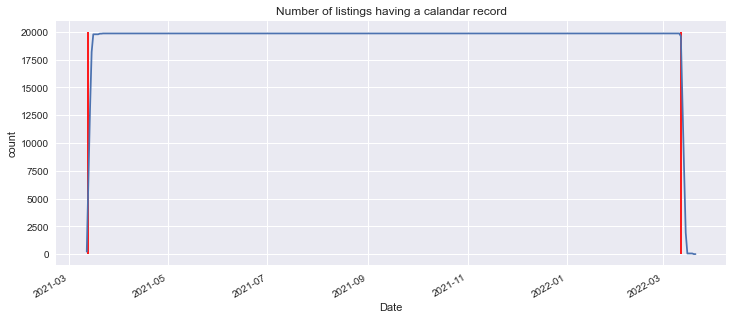

In [16]:
#
# how many listings have maintained calendar between 13-03-2021 until 2022-03-12
#
ax = ser_tmp.plot(figsize=(12,5))
plt.vlines(x=pd.to_datetime('2021-03-13'),ymin=0, ymax=20000, color='red')
plt.vlines(x=pd.to_datetime('2022-03-12'),ymin=0, ymax=20000, color='red')
ax.set_title('Number of listings having a calandar record')
ax.set_xlabel('Date')
ax.set_ylabel('count')

We analyse for the period of one year - so we drop all entries befre 2021-03-13 and after 2022-03-11

In [17]:
df_calendar = df_calendar[(df_calendar['date']>'2021-03-13') & (df_calendar['date']<'2022-03-11')]

#### Listing Details

* add column host_since_in_days as num of days from diff of (todays - host_since)
* convert price to float
* remove columns with less than 75% of filled data

In [18]:
total_rows = df_listings_dtl.shape[0]
col_cnt = df_listings_dtl.count()

In [19]:
# host since in days until today
df_listings_dtl['host_since_in_days'] = dt.datetime.today()-pd.to_datetime(df_listings_dtl['host_since'])
df_listings_dtl['host_since_in_days'] = df_listings_dtl['host_since_in_days'].dt.days

# price as number
df_listings_dtl['price_n'] = df_listings_dtl['price'].str.slice(1).str.replace(',','').astype('float')

In [20]:
print('columns with less than 75% values')
col_cnt[col_cnt<0.75*total_rows] / df_listings_dtl.shape[0]


columns with less than 75% values


neighborhood_overview    0.537164
host_about               0.478598
host_response_time       0.383120
host_response_rate       0.383120
host_acceptance_rate     0.480008
host_neighbourhood       0.667993
neighbourhood            0.537214
bathrooms                0.000000
calendar_updated         0.000000
license                  0.116427
dtype: float64

In [21]:
# columns with less than 75% values
drop_col_list = col_cnt[col_cnt<0.75*total_rows]
drop_col_list.index.values

# drop columns with less than 75% of data
df_listings_dtl_cln = df_listings_dtl.copy()
df_listings_dtl_cln.drop(drop_col_list.index.values, axis=1, inplace=True)

#### Calulate avg price for each listing

avg price is also in df_listings_sum but we calculated it to see if it is up todate


In [22]:
id_avgprice = df_calendar.groupby(by='listing_id').mean()
df_listings_dtl_cln.drop( columns=['price_n','minimum_nights','maximum_nights'], inplace =True)
df_listings_dtl_cln =pd.merge(left=df_listings_dtl_cln, right=id_avgprice, left_on='id', right_on='listing_id')

In [23]:
df_tmp = pd.merge(left=df_listings_dtl_cln, right=df_listings_sum, on='id', suffixes=('_dtl','_sum'))[['id','price_dtl','price_n','price_sum']]

Are there any differences > 5%

In [24]:
df_tmp2 = df_tmp[(df_tmp['price_n']-df_tmp['price_sum']).abs()>df_tmp['price_n']*0.05]
print(f'Num of differences: {df_tmp2.shape[0]}')
print()
print('First 5 records')
df_tmp2.head()

Num of differences: 3744

First 5 records


,id,price_dtl,price_n,price_sum
1,2015,$59.00,71.500000,59
4,6883,$79.00,83.373596,79
15,24569,$211.00,187.375691,211
16,25653,$90.00,116.477901,90
46,68448,$60.00,159.733333,60


#### Geo Neighbourhood
This dataset **df_geo_nbh** defines the shapes (polygons) for neighbourhoods. we adjust the spelling in order to compare and merge it with data from **df_zip_nbh_grp**. So we get the zip codes for each neighbourhoodgroup

In [25]:
# remove white spaces
df_geo_nbh['neighbourhood_group'] = df_geo_nbh['neighbourhood_group'].str.replace(' ','')
df_geo_nbh['neighbourhood_group'].str.replace(' ','').unique()

array(['Pankow', 'Charlottenburg-Wilm.', 'Treptow-Köpenick',
       'Marzahn-Hellersdorf', 'Reinickendorf', 'Friedrichshain-Kreuzberg',
       None, 'Mitte', 'Spandau', 'Steglitz-Zehlendorf',
       'Tempelhof-Schöneberg', 'Lichtenberg', 'Neukölln'], dtype=object)

In [26]:
# check if all values in df_geo_nbh are in df_nbh_zip
unique_nbh_grp_names = pd.Series(df_geo_nbh['neighbourhood_group'].unique())
unique_nbhzip_grp_names = pd.Series(df_zip_nbh_grp['neighbourhood_group'].unique())

print('Neighbourhood Groups of AirBnB Dataset that are not contained in Neighbourhood to Zip Code mapping dataset:')
unique_nbh_grp_names[~unique_nbh_grp_names.isin(unique_nbhzip_grp_names)]

Neighbourhood Groups of AirBnB Dataset that are not contained in Neighbourhood to Zip Code mapping dataset:


6    None
dtype: object

In [27]:
df_geo_nbh.head(2)

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."


In [28]:
df_zip_nbh_grp.head(2)

,zip,neighbourhood_group
0,10115,Mitte
1,10117,Mitte


#### Zip Code Shapes

In [29]:
# some areas have more than one polygon
df_zip_shape[df_zip_shape['zip']=='12059']

,zip,note,geometry
8357,12059,12059 Berlin Neukölln,"POLYGON ((13.43944 52.48963, 13.43963 52.48966..."
8362,12059,12059 Berlin Neukölln,"POLYGON ((13.44245 52.47972, 13.44269 52.47989..."


In [30]:
#df_zip_shape.drop_duplicates(subset=['zip'], inplace = True)
# 8725

### Feature Columns
Define which columns are considred as feature candidates for further analysis.

* remove columns that obviously not needed like URL
* remove columns that have almost no variances like host_has_profile_pic

In [31]:
all_columns = df_listings_dtl_cln.columns.values
all_columns

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'description', 'picture_url', 'host_id', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities',
       'price', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_

In [32]:
feature_cols_set_1 = [ 'host_is_superhost',  
                       'host_identity_verified', 
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'minimum_nights', 'maximum_nights',       
        'has_availability', 
        'number_of_reviews',       
       'review_scores_rating', 'instant_bookable',    
        'calculated_host_listings_count',
        'host_since_in_days', 'price_n']

In [33]:
# check that feature_cols_set_1 is contained in columns - 
assert set(feature_cols_set_1) - set(df_listings_dtl_cln.columns.values) == set()

In [34]:
df_listings_dtl_cln[feature_cols_set_1].head(2)

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,has_availability,number_of_reviews,review_scores_rating,instant_bookable,calculated_host_listings_count,host_since_in_days,price_n
0,f,t,Brunnenstr. Nord,Mitte,52.54425,13.39749,Private room in apartment,Private room,1,1 shared bath,1.0,1.0,"[""Dishes and silverware"", ""Kitchen"", ""Oven"", ""...",60.000000,120.0,t,18,82.0,f,3,4671.0,20.712707
1,f,t,Brunnenstr. Süd,Mitte,52.53454,13.40256,Entire guesthouse,Entire home/apt,3,1 bath,1.0,0.0,"[""Smoke alarm"", ""Cooking basics"", ""Lockbox"", ""...",11.247191,1125.0,t,135,93.0,f,6,4669.0,71.500000


## Second Look at the Data

review the remaining data second time

#### Price distribution

In [35]:
print(f"Min price: {df_listings_dtl_cln['price_n'].min()}")
print(f"Max price: {df_listings_dtl_cln['price_n'].max()}")

Min price: 0.0
Max price: 8000.0


<AxesSubplot:>

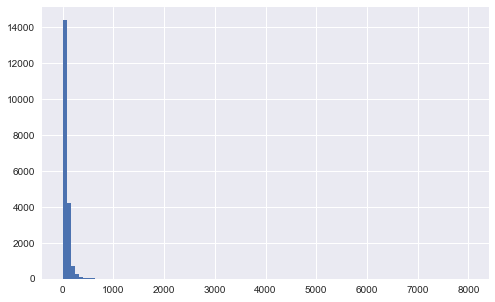

In [36]:
df_listings_dtl_cln['price_n'].hist(bins=100, figsize=(8,5))

Text(0, 0.5, 'count')

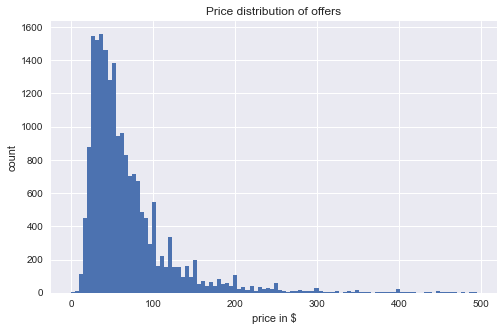

In [37]:
ax = df_listings_dtl_cln[df_listings_dtl_cln['price_n']<500]['price_n'].hist(bins=100, figsize=(8,5))
ax.set_title('Price distribution of offers')
ax.set_xlabel('price in $')
ax.set_ylabel('count')

In [38]:
df_listings_dtl_cln['price_n'].describe(percentiles=[0.25,0.5,0.75,0.8,0.85,0.9,0.95,0.975])

count    19851.000000
mean        73.746901
std        113.903209
min          0.000000
25%         35.000000
50%         52.000000
75%         81.474404
80%         91.550000
85%        105.134369
90%        129.000000
95%        180.000000
97.5%      242.000000
max       8000.000000
Name: price_n, dtype: float64

In [39]:
df_listings_dtl_cln['price_n'].describe

<bound method NDFrame.describe of 0          20.712707
1          71.500000
2          90.000000
3          28.563536
4          83.373596
5          33.000000
6         181.606648
7          70.000000
8          90.000000
9          49.972222
10        159.331492
11         70.000000
12         65.000000
13        160.000000
14         65.000000
15        187.375691
16        116.477901
17         80.000000
18         80.000000
19        127.963483
20         62.000000
21         27.382271
22         75.000000
23         35.000000
24         35.000000
            ...     
19826      28.000000
19827      75.000000
19828      37.414365
19829      85.000000
19830      35.000000
19831      27.005525
19832     110.000000
19833      50.000000
19834     140.000000
19835      64.127424
19836      40.000000
19837      25.002762
19838      28.958564
19839      60.000000
19840      93.927978
19841      70.000000
19842      65.110497
19843      24.027624
19844      30.675900
19845      65.000000


In [40]:
print(f"Share of listings with avg price < 250$: {df_listings_dtl_cln[df_listings_dtl_cln['price_n']<250]['id'].count()/df_listings_dtl_cln.shape[0]:6.4f}")

Share of listings with avg price < 250$: 0.9769


As more than 97.7% of all listings are within the price range 0-250$ we will restrict the analysis on these records.

In [41]:
# without price
df_listings_dtl_cln[df_listings_dtl_cln['price_n']==0]['id'].count()/df_listings_dtl_cln.shape[0]

0.0003022517757291824

In [42]:
df_listings_dtl_cln = df_listings_dtl_cln[(df_listings_dtl_cln['price_n']<250) & (df_listings_dtl_cln['price_n']>0)]

#### Dirstribution of the remaining data

In [43]:
t = df_listings_dtl_cln[feature_cols_set_1]
t = t.drop(columns=['amenities','longitude','latitude','minimum_nights','maximum_nights','has_availability','number_of_reviews','review_scores_rating','host_since_in_days','calculated_host_listings_count','price_n'])
t
for col in t.columns:
    print(f'{col}: ')
    print(f'{t[col].value_counts().head(20)}')
    
    print()

host_is_superhost: 
f    15522
t     2946
Name: host_is_superhost, dtype: int64

host_identity_verified: 
t    13846
f     4622
Name: host_identity_verified, dtype: int64

neighbourhood_cleansed: 
Frankfurter Allee Süd FK    1101
Alexanderplatz              1014
Tempelhofer Vorstadt        1000
Reuterstraße                 815
Brunnenstr. Süd              692
Rixdorf                      633
Neuköllner Mitte/Zentrum     592
südliche Luisenstadt         560
Prenzlauer Berg Südwest      547
Prenzlauer Berg Nordwest     536
Frankfurter Allee Nord       524
Prenzlauer Berg Süd          471
Schöneberg-Nord              470
Schillerpromenade            456
Wedding Zentrum              418
Moabit West                  418
Helmholtzplatz               386
Moabit Ost                   368
Schöneberg-Süd               367
nördliche Luisenstadt        347
Name: neighbourhood_cleansed, dtype: int64

neighbourhood_group_cleansed: 
Friedrichshain-Kreuzberg    4403
Mitte                       4186
Pa

#### Data wrangling - Simplification of listings dataset

We simplfy the data like this
* beds
    * 1, 2, 3, 4, more
* bedrooms
    * 1,2,more
    
* bathrooms_text
    1 bath, 1 shared bath, 2 or more bath, 2 or more shared

* property_type
    * Entire apartment                      
    * Private room in apartment             
    * Entire serviced apartment              
    * Entire condominium                     
    * Entire loft                            
    * Private room in house                  
    * Private room in condominium            
    * Entire house                           
    * Shared room in apartment               
    * Room in hotel    
    * **others**
    

In [44]:
# adjust  property type
sel = df_listings_dtl_cln ['property_type'].value_counts() < df_listings_dtl_cln.shape[0] * 0.01
df_listings_dtl_cln.loc[df_listings_dtl_cln['property_type'].isin(sel[sel==True].index.values),'property_type'] = 'others'

In [45]:
df_listings_dtl_cln.loc[df_listings_dtl_cln['bathrooms_text'].str.find('shared')<0,'bathrooms_text'].unique()

array(['1 bath', '2.5 baths', '1 private bath', '2 baths', '1.5 baths',
       '0 baths', 'Half-bath', 'Shared half-bath', '7 baths', '7.5 baths',
       '3 baths', 'Private half-bath', '8 baths', '4 baths', '3.5 baths',
       '4.5 baths', '50 baths', '32 baths', '18 baths'], dtype=object)

In [46]:
df_listings_dtl_cln.loc[df_listings_dtl_cln['bathrooms_text']=='1 private bath','bathrooms_text'] = '1 bath'
df_listings_dtl_cln.loc[df_listings_dtl_cln['bathrooms_text'].isin(['1 shared baths','Half-bath','Private half-bath']),'bathrooms_text'] = '1 shared bath'

df_listings_dtl_cln.loc[df_listings_dtl_cln['bathrooms_text'].isin(['1.5 shared baths','2 shared baths', '2.5 shared baths', '3 shared baths','4 shared baths', '5 shared baths', '3.5 shared baths','8.5 shared baths', '14 shared baths']),'bathrooms_text'] = '2 or more shared bath'
df_listings_dtl_cln.loc[df_listings_dtl_cln['bathrooms_text'].isin(['2.5 baths', '2 baths', '1.5 baths','7 baths', '7.5 baths','3 baths', '8 baths', '4 baths', '3.5 baths', '4.5 baths', '50 baths', '32 baths', '18 baths']),'bathrooms_text'] = '2 or more bath'

df_listings_dtl_cln.loc[df_listings_dtl_cln['bathrooms_text'].isin(['0 shared baths','0 baths','Shared half-bath']),'bathrooms_text'] = 'no bath'



In [47]:
df_listings_dtl_cln.loc[df_listings_dtl_cln['bedrooms'] >2, 'bedrooms']=99.0
df_listings_dtl_cln.loc[df_listings_dtl_cln['beds'] >4, 'beds']=99.0

df_listings_dtl_cln['bedrooms'] = df_listings_dtl_cln['bedrooms'].astype('str')
df_listings_dtl_cln['beds'] = df_listings_dtl_cln['beds'].astype('str')
df_listings_dtl_cln.loc[df_listings_dtl_cln['bedrooms'] =='99.0', 'bedrooms']='3 or more'
df_listings_dtl_cln.loc[df_listings_dtl_cln['beds'] =='99.0', 'beds']='5 or more'

In [48]:
sel = df_listings_dtl_cln ['neighbourhood_cleansed'].value_counts() < df_listings_dtl_cln.shape[0] * 0.01
df_listings_dtl_cln.loc[df_listings_dtl_cln['neighbourhood_cleansed'].isin(sel[sel==True].index.values),'neighbourhood_cleansed'] = 'others'

In [49]:
df_listings_dtl_cln['beds'].value_counts()

1.0          11313
2.0           4576
3.0           1293
4.0            712
0.0            656
5 or more      615
nan            221
Name: beds, dtype: int64

<ipython-input-50-cd079a3551c9>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(labels, rotation=80, horizontalalignment='center');


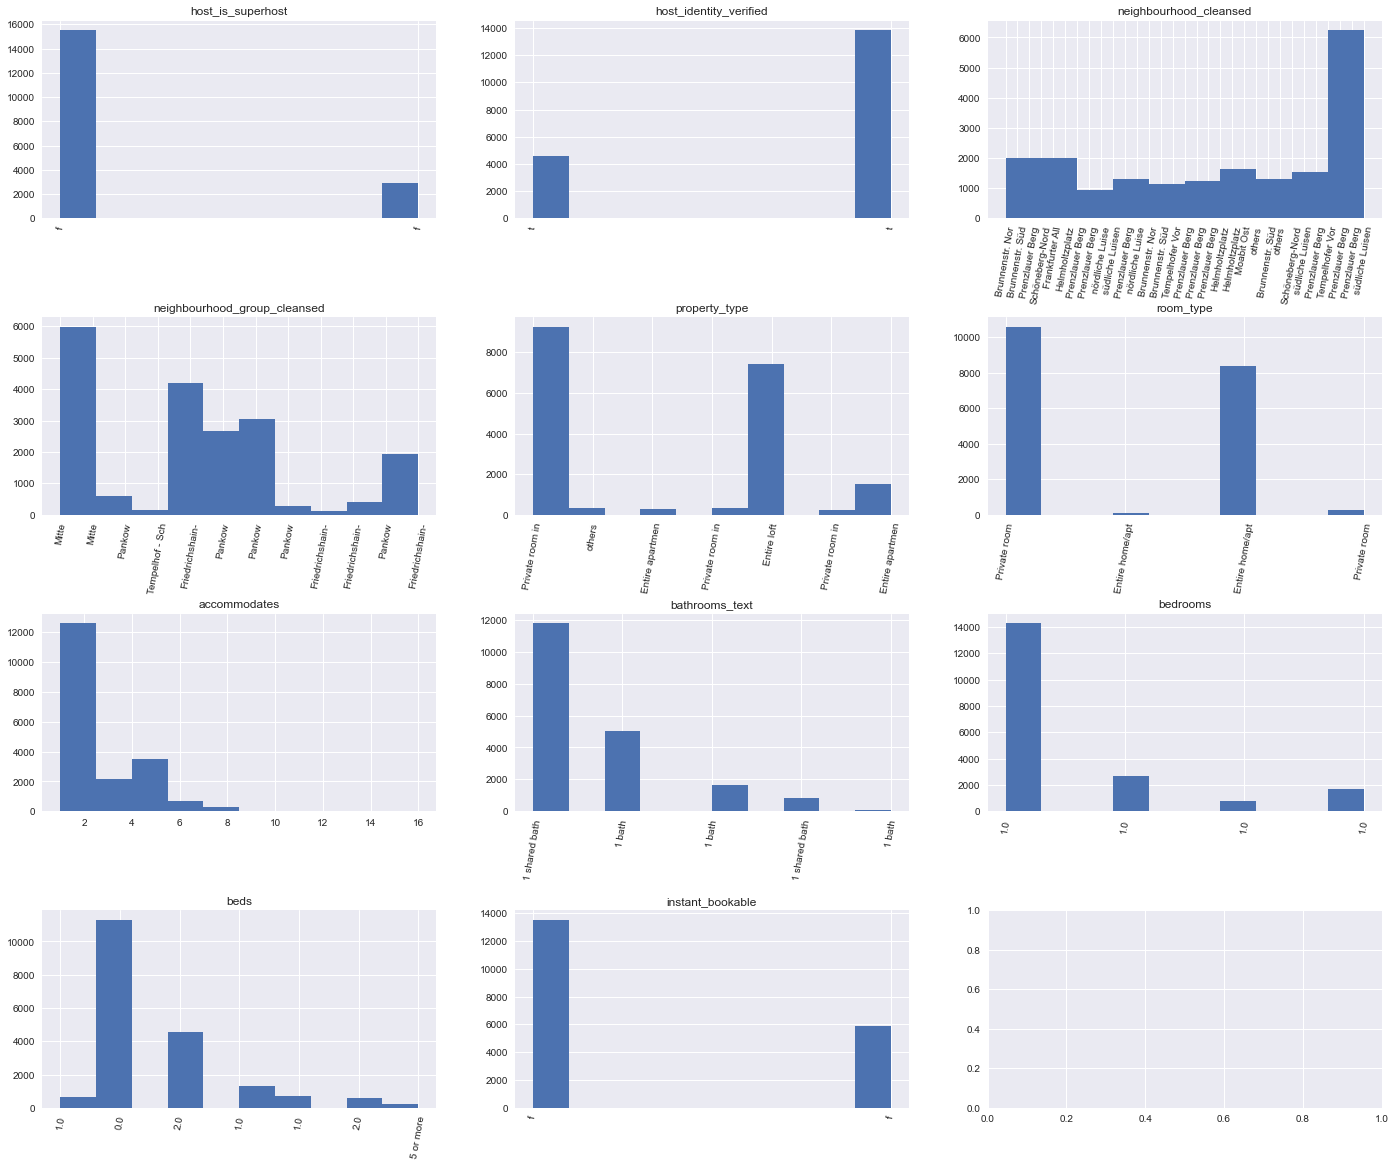

In [50]:
fig, ax = plt.subplots(4,3, figsize=(24,20));
fig.subplots_adjust(hspace=0.5)

t = df_listings_dtl_cln[feature_cols_set_1]
t = t.drop(columns=['amenities','longitude','latitude','minimum_nights','maximum_nights','has_availability','number_of_reviews','review_scores_rating','host_since_in_days','calculated_host_listings_count','price_n'])

for i, fea in enumerate(t.columns):
    chart = t[fea].sort_values().hist(ax=ax[i//3,i%3]);
    if t[fea].dtype=='object':
        labels = t[fea].str.slice(0,15).values
        chart.set_xticklabels(labels, rotation=80, horizontalalignment='center');       
    ax[i//3,i%3].set_title(fea)    

## Q1 - In which Neighbourhoods are the most offers
we will now analyse in how the listing locations are distributed across Berlin and compare it with the population distribution. 

### Merge AirBnB listing with zip code areas
we use the **df_berlin_zip_pop** dataframe geometry column which defines a zip code area to find the zip code for a record of the **df_listings_sum** / **df_listings_dtl** by using the longitude and latitude coordinates. In order to check in which zip code area a given geo-location-point is we use the **geopandas** gemometry operations.

In [51]:
df_berlin_zip_pop = pd.merge(
    left  = df_zip_population, 
    right = df_zip_region, 
    on    = 'zip',
    how   = 'inner'
)

df_berlin_zip_pop = pd.merge(  left = df_zip_shape, right=df_berlin_zip_pop,   on    = 'zip',    how   = 'inner')


# restrict data set to Berlin city
df_berlin_zip_pop = df_berlin_zip_pop[df_berlin_zip_pop['city']=='Berlin']



# set coordination reference system - see https://geopandas.org/docs/user_guide/projections.html
df_berlin_zip_pop.set_crs(epsg=4326, inplace=True);
# convert to a coordinate system that can be used to calculate areas
df_berlin_zip_pop['area'] = df_berlin_zip_pop.to_crs('epsg:6933').area/(1e+06)
#df_berlin_zip_pop['area'] = 
df_berlin_zip_pop = pd.merge(left=df_berlin_zip_pop, right=df_berlin_zip_pop.groupby(by='zip')['area'].sum(),on='zip')
df_berlin_zip_pop.rename(columns= {'area_x':'area','area_y':'tot_zip_area'}, inplace=True);

df_berlin_zip_pop['pop_per_sqkm'] = df_berlin_zip_pop['population'] / df_berlin_zip_pop['tot_zip_area']

df_pop = df_berlin_zip_pop.drop_duplicates(subset=['zip'])
print(f"Total Population of Berlin: {df_pop['population'].sum()}")
df_berlin_zip_pop.head(3)

Total Population of Berlin: 3291932


,zip,note,geometry,population,city,state,area,tot_zip_area,pop_per_sqkm
0,14109,14109 Berlin Wannsee,"POLYGON ((13.08835 52.41963, 13.09584 52.42198...",10049,Berlin,Berlin,25.228861,25.228861,398.313655
1,14089,14089 Berlin Gatow,"POLYGON ((13.10929 52.45063, 13.10956 52.45108...",17734,Berlin,Berlin,24.888003,24.888003,712.552149
2,13591,13591 Berlin Staaken,"POLYGON ((13.11738 52.51706, 13.11811 52.52010...",26762,Berlin,Berlin,8.988002,8.988002,2977.524840


In [52]:
df_berlin_zip_pop[df_berlin_zip_pop.duplicated(subset='zip', keep=False)].sort_values(by='zip').head()

,zip,note,geometry,population,city,state,area,tot_zip_area,pop_per_sqkm
57,10623,10623 Berlin Charlottenburg,"POLYGON ((13.31776 52.50592, 13.31781 52.50626...",5680,Berlin,Berlin,1.160038,1.168557,4860.697046
58,10623,10623 Berlin Charlottenburg,"POLYGON ((13.31837 52.50216, 13.31841 52.50239...",5680,Berlin,Berlin,0.008519,1.168557,4860.697046
147,12059,12059 Berlin Neukölln,"POLYGON ((13.43944 52.48963, 13.43963 52.48966...",16237,Berlin,Berlin,0.131985,1.218942,13320.564308
148,12059,12059 Berlin Neukölln,"POLYGON ((13.44245 52.47972, 13.44269 52.47989...",16237,Berlin,Berlin,1.086957,1.218942,13320.564308
100,12107,12107 Berlin Mariendorf,"POLYGON ((13.36646 52.43913, 13.37151 52.43980...",19767,Berlin,Berlin,4.374302,4.407985,4484.362234


In [53]:
# step 1 - define geometry point for geo coordinates
df_listings_sum_geo =  gpd.GeoDataFrame(df_listings_dtl_cln, geometry=gpd.points_from_xy(df_listings_dtl_cln.longitude, df_listings_dtl_cln.latitude))

# this line sets the correct coordinate reference system - see https://geopandas.org/docs/user_guide/projections.html
df_listings_sum_geo.set_crs(epsg=4326, inplace=True);

join dataframes **df_listings_sum_geo** and **df_berlin_zip_pop** by using the location point of an offer and checking in which zip code area it is contained 

In [54]:
df_listings_sum_geo = gpd.sjoin(df_listings_sum_geo, df_berlin_zip_pop, how="inner", op='intersects');
df_listings_sum_geo.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,picture_url,host_id,host_url,host_name,host_since,host_location,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_in_days,minimum_nights,maximum_nights,price_n,adjusted_price_n,geometry,index_right,zip,note,population,city,state,area,tot_zip_area,pop_per_sqkm
0,1944,https://www.airbnb.com/rooms/1944,20210312174442,2021-03-14,bright & airy Pberg/Mitte 3 months or more,"Private, bright and friendly room. You'd be sh...",https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,Lulah,2008-08-16,"Berlin, Berlin, Germany",f,https://a0.muscache.com/im/users/2164/profile_...,https://a0.muscache.com/im/users/2164/profile_...,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Brunnenstr. Nord,Mitte,52.54425,13.39749,Private room in apartment,Private room,1,1 shared bath,1.0,1.0,"[""Dishes and silverware"", ""Kitchen"", ""Oven"", ""...",$20.00,60.0,60.0,120.0,120.0,60.0,120.0,t,0,27,27,251,2021-03-14,18,0,0,2013-09-07,2018-11-11,82.0,9.0,8.0,9.0,9.0,9.0,8.0,f,3,1,2,0,0.20,4671.0,60.0,120.0,20.712707,20.712707,POINT (13.39749 52.54425),108,13355,13355 Berlin Wedding,21174,Berlin,Berlin,1.674738,1.674738,12643.174424
12,22438,https://www.airbnb.com/rooms/22438,20210312174442,2021-03-16,WOHNUNG IN BERLIN ★ MITTE,Free Internet and phone included.<br /><br />A...,https://a0.muscache.com/pictures/a1b801aa-db65...,86159,https://www.airbnb.com/users/show/86159,Javier,2010-02-27,"Berlin, Berlin, Germany",f,https://a0.muscache.com/im/users/86159/profile...,https://a0.muscache.com/im/users/86159/profile...,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Brunnenstr. Nord,Mitte,52.53445,13.38837,Entire apartment,Entire home/apt,2,1 bath,2.0,4.0,"[""Washer"", ""Long term stays allowed"", ""TV"", ""H...",$65.00,90.0,90.0,365.0,365.0,90.0,365.0,t,0,0,0,252,2021-03-16,181,1,0,2011-04-05,2020-11-30,94.0,10.0,9.0,10.0,10.0,9.0,10.0,f,1,1,0,0,1.49,4111.0,90.0,365.0,65.000000,65.000000,POINT (13.38837 52.53445),108,13355,13355 Berlin Wedding,21174,Berlin,Berlin,1.674738,1.674738,12643.174424


In [55]:
# 
# calculate some basic statistics
#
df_listings_sum_geo_grpzip = df_listings_sum_geo.groupby('zip')
df_stat_pricebyzip = df_listings_sum_geo_grpzip['price_n'].describe()

# calculate basic stats
df_stat_pricebyzip.rename({'mean':'price_mean','std':'price_std','min':'price_min','25%':'price_25%','50%':'price_50%','75%':'price_75%','max':'price_max','median':'price_median'}, inplace=True, axis=1)

# merge data frames
df_berlin_zip_pop = pd.merge(left=df_berlin_zip_pop, right=df_stat_pricebyzip, on='zip', how='left')
df_listings_sum_geo = pd.merge(left=df_listings_sum_geo, right=df_stat_pricebyzip, on='zip', how='inner')

# remove areas with less than 10 offers

df_berlin_zip_pop['price_median_adj']= df_berlin_zip_pop['price_50%']
df_berlin_zip_pop.loc[df_berlin_zip_pop['count']<10,'price_median_adj']= np.NaN

In [56]:
df_listings_sum_geo.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,picture_url,host_id,host_url,host_name,host_since,host_location,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_in_days,minimum_nights,maximum_nights,price_n,adjusted_price_n,geometry,index_right,zip,note,population,city,state,area,tot_zip_area,pop_per_sqkm,count,price_mean,price_std,price_min,price_25%,price_50%,price_75%,price_max
0,1944,https://www.airbnb.com/rooms/1944,20210312174442,2021-03-14,bright & airy Pberg/Mitte 3 months or more,"Private, bright and friendly room. You'd be sh...",https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,Lulah,2008-08-16,"Berlin, Berlin, Germany",f,https://a0.muscache.com/im/users/2164/profile_...,https://a0.muscache.com/im/users/2164/profile_...,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Brunnenstr. Nord,Mitte,52.54425,13.39749,Private room in apartment,Private room,1,1 shared bath,1.0,1.0,"[""Dishes and silverware"", ""Kitchen"", ""Oven"", ""...",$20.00,60.0,60.0,120.0,120.0,60.0,120.0,t,0,27,27,251,2021-03-14,18,0,0,2013-09-07,2018-11-11,82.0,9.0,8.0,9.0,9.0,9.0,8.0,f,3,1,2,0,0.20,4671.0,60.0,120.0,20.712707,20.712707,POINT (13.39749 52.54425),108,13355,13355 Berlin Wedding,21174,Berlin,Berlin,1.674738,1.674738,12643.174424,108.0,60.395671,34.393886,15.0,38.0,51.291436,71.267579,180.085635
1,22438,https://www.airbnb.com/rooms/22438,20210312174442,2021-03-16,WOHNUNG IN BERLIN ★ MITTE,Free Internet and phone included.<br /><br />A...,https://a0.muscache.com/pictures/a1b801aa-db65...,86159,https://www.airbnb.com/users/show/86159,Javier,2010-02-27,"Berlin, Berlin, Germany",f,https://a0.muscache.com/im/users/86159/profile...,https://a0.muscache.com/im/users/86159/profile...,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Brunnenstr. Nord,Mitte,52.53445,13.38837,Entire apartment,Entire home/apt,2,1 bath,2.0,4.0,"[""Washer"", ""Long term stays allowed"", ""TV"", ""H...",$65.00,90.0,90.0,365.0,365.0,90.0,365.0,t,0,0,0,252,2021-03-16,181,1,0,2011-04-05,2020-11-30,94.0,10.0,9.0,10.0,10.0,9.0,10.0,f,1,1,0,0,1.49,4111.0,90.0,365.0,65.000000,65.000000,POINT (13.38837 52.53445),108,13355,13355 Berlin Wedding,21174,Berlin,Berlin,1.674738,1.674738,12643.174424,108.0,60.395671,34.393886,15.0,38.0,51.291436,71.267579,180.085635


### Population per neighbourhood_group

In [57]:
df_pop_nbh_grp = pd.merge(df_zip_nbh_grp, df_zip_population, on ='zip', how='inner')
df_zip_count = df_pop_nbh_grp[['zip']].value_counts()
df_pop_nbh_grp = pd.merge(df_pop_nbh_grp, df_zip_count.reset_index().rename(columns={0:'count'}), on='zip', how='inner')
df_pop_nbh_grp['population']= np.round(df_pop_nbh_grp['population'] / df_pop_nbh_grp['count'])

In [58]:
df_pop_nbh_grp.groupby('neighbourhood_group')['population'].sum().sort_values()
#df_pop_nbh_grp.groupby('neighbourhood_group')['population'].sum().sum()


neighbourhood_group
Spandau                     210612.0
Friedrichshain-Kreuzberg    216027.0
Lichtenberg                 222565.0
Reinickendorf               225657.0
Treptow-Köpenick            238810.0
Marzahn-Hellersdorf         243741.0
Steglitz-Zehlendorf         287935.0
Charlottenburg-Wilm.        290806.0
Tempelhof-Schöneberg        303357.0
Neukölln                    321802.0
Mitte                       327772.0
Pankow                      402845.0
Name: population, dtype: float64

### Berlins Population

<AxesSubplot:>

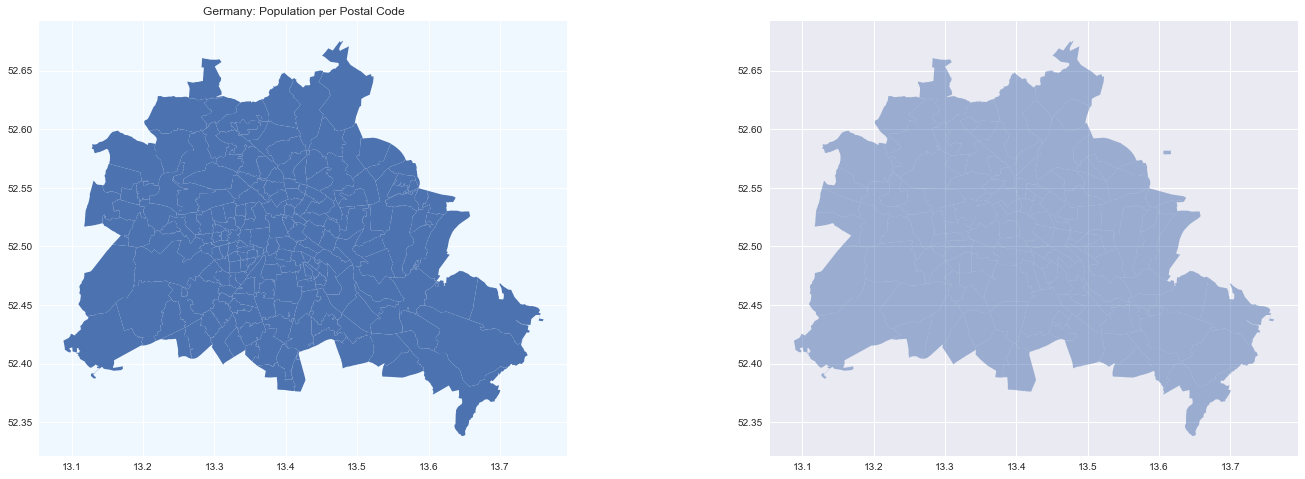

In [59]:
fig, ax = plt.subplots(1,2, figsize=(24,8))

df_berlin_zip_pop.plot(
    ax=ax[0], 
    alpha=1.0
)

    
ax[0].set(
    title='Germany: Population per Postal Code',     
    facecolor='aliceblue'
);

df_geo_nbh.plot(ax=ax[1], 
        alpha=0.5)

In [60]:
# Area of Berlin in km^2 
# epsg:6933 - see https://epsg.io/6933
print(f"Area of Berlin in square km:' {df_geo_nbh.to_crs('epsg:6933').area.sum()/(1e+06)}")

Area of Berlin in square km:' 891.3362049506509


In [61]:
df_geo_nbh.head(3)

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."


### Offer location distribution

The left diagram shows the offers per zip code area and population within the zip code area.
The right diagram shows the offers per zip code area and the median price per zip code area

In [62]:
df_berlin_zip_pop.head(2)

,zip,note,geometry,population,city,state,area,tot_zip_area,pop_per_sqkm,count,price_mean,price_std,price_min,price_25%,price_50%,price_75%,price_max,price_median_adj
0,14109,14109 Berlin Wannsee,"POLYGON ((13.08835 52.41963, 13.09584 52.42198...",10049,Berlin,Berlin,25.228861,25.228861,398.313655,30.0,81.114170,42.827686,20.0,56.741022,77.000000,88.0,200.000000,77.000000
1,14089,14089 Berlin Gatow,"POLYGON ((13.10929 52.45063, 13.10956 52.45108...",17734,Berlin,Berlin,24.888003,24.888003,712.552149,19.0,50.070247,29.792109,14.0,34.431490,44.786704,54.5,152.268698,44.786704


In [63]:
df_berlin_zip_pop.sort_values(by='pop_per_sqkm', ascending=False).head(3)

,zip,note,geometry,population,city,state,area,tot_zip_area,pop_per_sqkm,count,price_mean,price_std,price_min,price_25%,price_50%,price_75%,price_max,price_median_adj
134,12047,12047 Berlin Kreuzberg,"POLYGON ((13.42064 52.49562, 13.42097 52.49579...",13918,Berlin,Berlin,0.520633,0.520633,26732.844721,330.0,57.056200,30.149174,14.67313,37.0,50.0,70.000000,241.107735,50.0
142,12045,12045 Berlin Neukölln,"POLYGON ((13.43023 52.48592, 13.43054 52.48616...",15345,Berlin,Berlin,0.671722,0.671722,22844.254956,346.0,51.734748,28.465742,15.00000,32.0,45.0,65.000000,200.000000,45.0
138,12053,12053 Berlin Neukölln,"POLYGON ((13.42508 52.48198, 13.42550 52.48231...",15373,Berlin,Berlin,0.790892,0.790892,19437.534692,258.0,50.858773,32.176936,12.00000,30.0,42.0,60.002072,246.292818,42.0


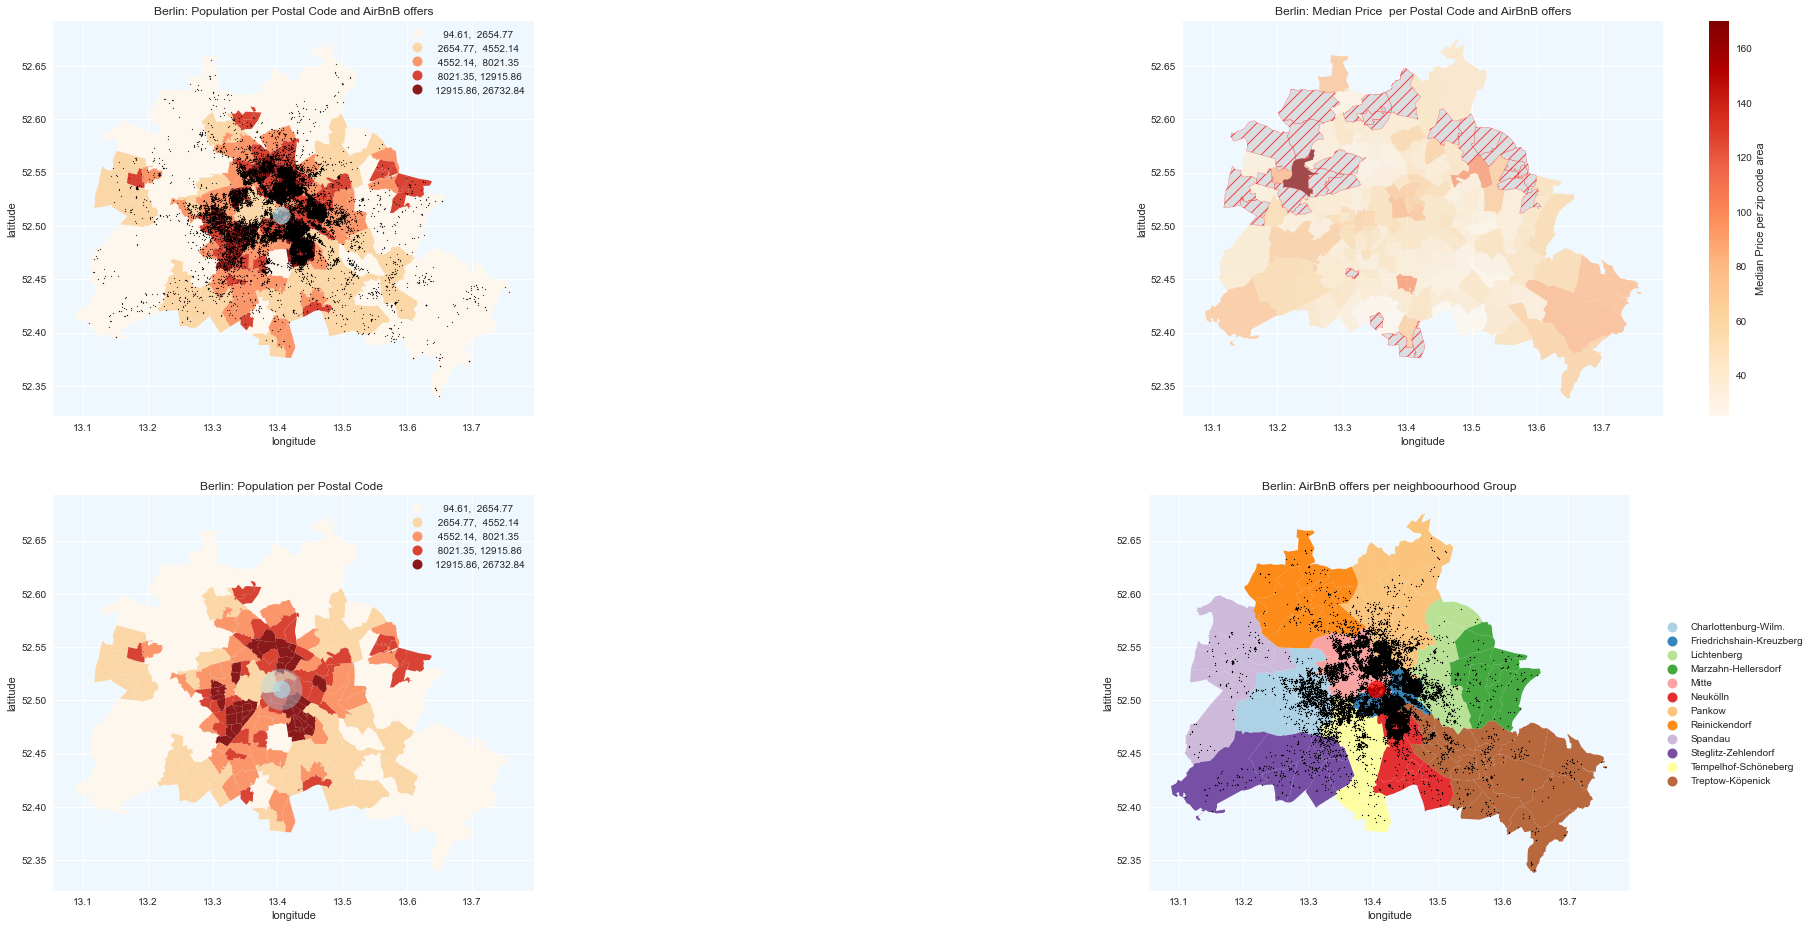

In [64]:
#
# draw 
#   AirBnB offer (listing) location distribution for Berlin - where are the offers located.
#   popultion distribution of Berlin
#
#


fig, ax = plt.subplots(2,2, figsize=(36,16))

center_point = df_listings_sum_geo[['longitude','latitude']].mean()
#center_point = Point(center_point)

df_berlin_zip_pop.plot(
    ax=ax[0,0], 
    column='pop_per_sqkm', 
    categorical=False, 
    legend=True, 
    cmap='OrRd',
    alpha=0.9,
    scheme='quantiles'
)


df_berlin_zip_pop.plot(
    ax=ax[1,0], 
    column='pop_per_sqkm', 
    categorical=False, 
    legend=True, 
    cmap='OrRd',
    alpha=0.9,
    scheme='quantiles'
)


df_listings_sum_geo['geometry'].plot(ax=ax[0,0],color='black', markersize=1, alpha=0.7);

ax[0,0].set(
    title='Berlin: Population per Postal Code and AirBnB offers', 
    #aspect=1.4, 
    facecolor='aliceblue',
    xlabel='longitude',
    ylabel='latitude'
);

ax[1,0].set(
    title='Berlin: Population per Postal Code ', 
    #aspect=1.4, 
    facecolor='aliceblue',
    xlabel='longitude',
    ylabel='latitude'
);

# draw the center
ax[0,0].scatter(center_point['longitude'], center_point['latitude'], s=300, color='lightblue', alpha=0.7)
ax[1,0].scatter(center_point['longitude'], center_point['latitude'], s=1700, color='lightblue', alpha=0.4)
ax[1,0].scatter(center_point['longitude'], center_point['latitude'], s=300, color='lightblue', alpha=0.7)

######################################################################

df_berlin_zip_pop.plot(
    ax=ax[0,1], 
    column='price_median_adj', 
    categorical=False, 
    legend=True, 
    cmap='OrRd',
    alpha=0.7,    
    #missing_kwds={'color': 'lightgrey'}
    legend_kwds={'label': "Median Price per zip code area",                
                           'orientation': "vertical"},
    missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "//",
            "label": "Missing values"            
        }
)

#df_listings_sum_geo['geometry'].plot(ax=ax[0,1],color='black', markersize=1);

ax[0,1].set(
    title='Berlin: Median Price  per Postal Code and AirBnB offers', 
    #aspect=1.4, 
    facecolor='aliceblue',
    xlabel='longitude',
    ylabel='latitude'            
);


# draw it per neighbourhood
df = pd.merge(left=df_geo_nbh, right=df_listings_sum, on='neighbourhood_group', how='inner')
df.drop('geometry', axis=1, inplace=True)
df.rename(columns={'geometry_y':'geometry'}, inplace=True)
df.head()

df_geo_nbh.plot(    
    ax=ax[1,1], 
    column='neighbourhood_group', 
    categorical=True, 
    legend=True,     
    cmap='Paired',
    alpha=0.9,
    legend_kwds={'bbox_to_anchor' : (1.05, 0.7) }
)

    
df_listings_sum_geo['geometry'].plot(ax=ax[1,1],color='black', markersize=1);

#ax[1,0].legend(loc='right')
ax[1,1].set(
    title='Berlin: AirBnB offers per neighboourhood Group', 
    #aspect=1.4,     
    facecolor='aliceblue',
    xlabel='longitude',
    ylabel='latitude'
);

ax[1,1].scatter(center_point['longitude'], center_point['latitude'], s=300, color='red', alpha=0.7)


In [65]:
# center of all location listings
df_listings_sum_geo[['longitude','latitude']].mean()

longitude    13.404860
latitude     52.510283
dtype: float64

In [66]:
df_berlin_zip_pop[['zip','pop_per_sqkm','note']].nlargest(5, columns='pop_per_sqkm')

,zip,pop_per_sqkm,note
134,12047,26732.844721,12047 Berlin Kreuzberg
142,12045,22844.254956,12045 Berlin Neukölln
138,12053,19437.534692,12053 Berlin Neukölln
137,12043,19082.371368,12043 Berlin Neukölln
119,10437,18903.732955,10437 Berlin Prenzlauer Berg


In [67]:
df_listings_sum_geo.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,picture_url,host_id,host_url,host_name,host_since,host_location,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_in_days,minimum_nights,maximum_nights,price_n,adjusted_price_n,geometry,index_right,zip,note,population,city,state,area,tot_zip_area,pop_per_sqkm,count,price_mean,price_std,price_min,price_25%,price_50%,price_75%,price_max
0,1944,https://www.airbnb.com/rooms/1944,20210312174442,2021-03-14,bright & airy Pberg/Mitte 3 months or more,"Private, bright and friendly room. You'd be sh...",https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,Lulah,2008-08-16,"Berlin, Berlin, Germany",f,https://a0.muscache.com/im/users/2164/profile_...,https://a0.muscache.com/im/users/2164/profile_...,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Brunnenstr. Nord,Mitte,52.54425,13.39749,Private room in apartment,Private room,1,1 shared bath,1.0,1.0,"[""Dishes and silverware"", ""Kitchen"", ""Oven"", ""...",$20.00,60.0,60.0,120.0,120.0,60.0,120.0,t,0,27,27,251,2021-03-14,18,0,0,2013-09-07,2018-11-11,82.0,9.0,8.0,9.0,9.0,9.0,8.0,f,3,1,2,0,0.20,4671.0,60.0,120.0,20.712707,20.712707,POINT (13.39749 52.54425),108,13355,13355 Berlin Wedding,21174,Berlin,Berlin,1.674738,1.674738,12643.174424,108.0,60.395671,34.393886,15.0,38.0,51.291436,71.267579,180.085635
1,22438,https://www.airbnb.com/rooms/22438,20210312174442,2021-03-16,WOHNUNG IN BERLIN ★ MITTE,Free Internet and phone included.<br /><br />A...,https://a0.muscache.com/pictures/a1b801aa-db65...,86159,https://www.airbnb.com/users/show/86159,Javier,2010-02-27,"Berlin, Berlin, Germany",f,https://a0.muscache.com/im/users/86159/profile...,https://a0.muscache.com/im/users/86159/profile...,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Brunnenstr. Nord,Mitte,52.53445,13.38837,Entire apartment,Entire home/apt,2,1 bath,2.0,4.0,"[""Washer"", ""Long term stays allowed"", ""TV"", ""H...",$65.00,90.0,90.0,365.0,365.0,90.0,365.0,t,0,0,0,252,2021-03-16,181,1,0,2011-04-05,2020-11-30,94.0,10.0,9.0,10.0,10.0,9.0,10.0,f,1,1,0,0,1.49,4111.0,90.0,365.0,65.000000,65.000000,POINT (13.38837 52.53445),108,13355,13355 Berlin Wedding,21174,Berlin,Berlin,1.674738,1.674738,12643.174424,108.0,60.395671,34.393886,15.0,38.0,51.291436,71.267579,180.085635


In [68]:
# offers per Neighbourhood Group
df_listings_sum_geo.groupby(by='neighbourhood_group_cleansed')['id'].count().sort_values()

neighbourhood_group_cleansed
Spandau                      135
Marzahn - Hellersdorf        139
Reinickendorf                278
Steglitz - Zehlendorf        395
Lichtenberg                  605
Treptow - Köpenick           628
Tempelhof - Schöneberg      1302
Charlottenburg-Wilm.        1582
Neukölln                    2681
Pankow                      3049
Mitte                       4186
Friedrichshain-Kreuzberg    4403
Name: id, dtype: int64

### Result 1-1

The AirBnB offers are concentrated in the center of Berlin around (13.404372, 52,510220) (long, lat).
The most offers are in Friedrichshain-Kreuzberg and Mitte. The areas with the most offers are also the post populated center areas.

In [69]:
grp_zip = df_listings_sum_geo.groupby('zip')

<AxesSubplot:xlabel='zip'>

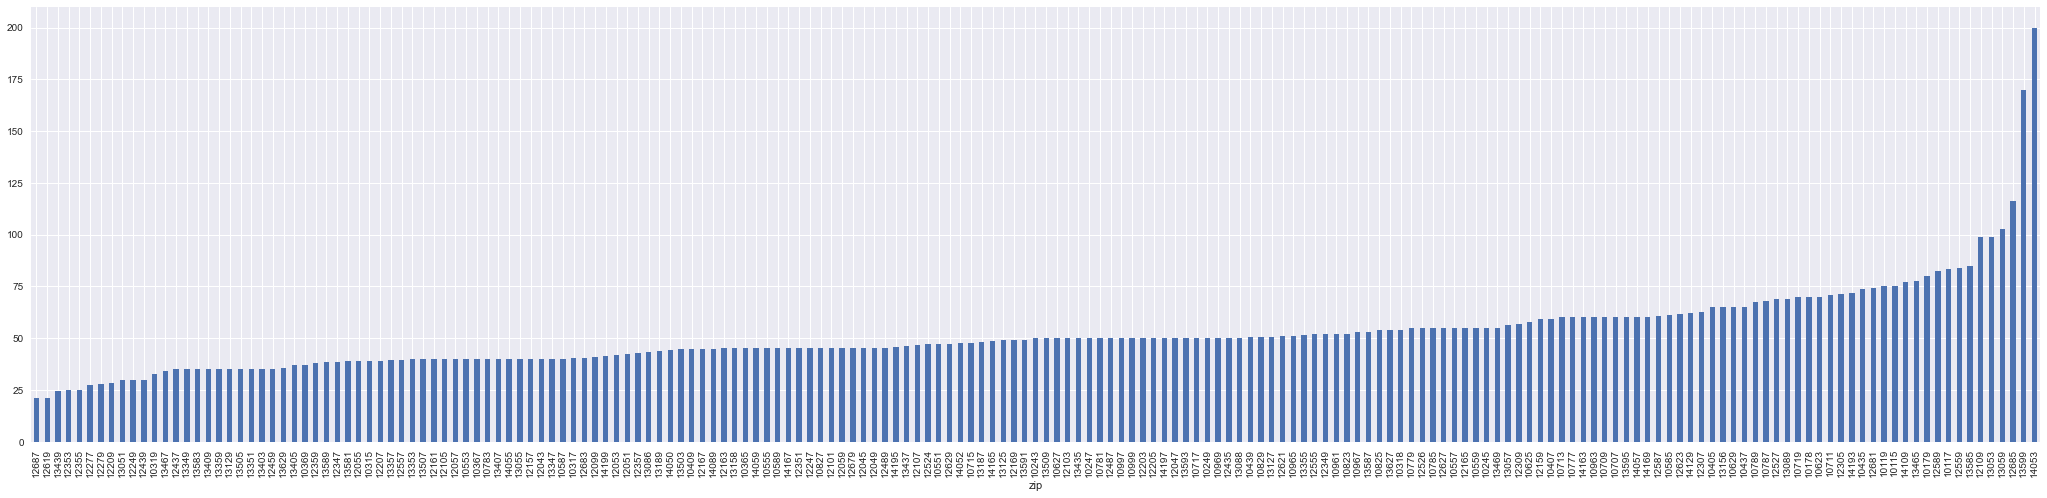

In [70]:
ser_median = grp_zip['price_n'].median()
ser_median.sort_values().plot.bar(figsize=(36,8))

In [71]:
nlargest = 5
ser_median.nlargest(nlargest)

zip
14053    200.000000
13599    170.000000
12685    116.361496
13059    102.500000
12109     99.000000
Name: price_n, dtype: float64

In [72]:
df_top = df_listings_sum_geo[df_listings_sum_geo['zip'].isin(ser_median.nlargest(nlargest).index)]
print()
print(df_top.shape)
df_top.head(3)


(30, 85)


,id,listing_url,scrape_id,last_scraped,name,description,picture_url,host_id,host_url,host_name,host_since,host_location,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_in_days,minimum_nights,maximum_nights,price_n,adjusted_price_n,geometry,index_right,zip,note,population,city,state,area,tot_zip_area,pop_per_sqkm,count,price_mean,price_std,price_min,price_25%,price_50%,price_75%,price_max
18940,6315422,https://www.airbnb.com/rooms/6315422,20210312174442,2021-03-16,"75 qm flat in a quiet, green area","Flat in Wartenberg, Berlin, 25 min from Alexan...",https://a0.muscache.com/pictures/83613966/3644...,32854189,https://www.airbnb.com/users/show/32854189,Tony,2015-05-07,"Paris, Île-de-France, France",f,https://a0.muscache.com/im/pictures/user/85b98...,https://a0.muscache.com/im/pictures/user/85b98...,1.0,1.0,"['email', 'phone']",t,f,others,Lichtenberg,52.57436,13.50841,Entire apartment,Entire home/apt,2,1 bath,1.0,1.0,"[""Washer"", ""Long term stays allowed"", ""Heating...",$85.00,1.0,1.0,1125.0,1125.0,1.0,1125.0,t,0,0,0,0,2021-03-16,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN,2216.0,1.0,1125.0,85.0,85.0,POINT (13.50841 52.57436),171,13059,13059 Berlin Wartenberg,14495,Berlin,Berlin,6.374397,6.374397,2273.940487,2.0,102.500000,24.748737,85.000000,93.750000,102.5,111.25,120.0
18941,45618089,https://www.airbnb.com/rooms/45618089,20210312174442,2021-03-16,Blackys Building,ruhig und doch zentral,https://a0.muscache.com/pictures/e1d33f65-6714...,369526565,https://www.airbnb.com/users/show/369526565,Doreen,2020-09-27,DE,f,https://a0.muscache.com/im/pictures/user/9bfdd...,https://a0.muscache.com/im/pictures/user/9bfdd...,0.0,0.0,"['email', 'phone', 'work_email']",t,f,others,Lichtenberg,52.58541,13.53516,Entire apartment,Entire home/apt,4,1 bath,2.0,2.0,"[""Dryer"", ""Hangers"", ""Dedicated workspace"", ""K...",$120.00,2.0,2.0,1125.0,1125.0,2.0,1125.0,t,0,0,0,0,2021-03-16,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN,246.0,2.0,1125.0,120.0,120.0,POINT (13.53516 52.58541),171,13059,13059 Berlin Wartenberg,14495,Berlin,Berlin,6.374397,6.374397,2273.940487,2.0,102.500000,24.748737,85.000000,93.750000,102.5,111.25,120.0
19019,7201979,https://www.airbnb.com/rooms/7201979,20210312174442,2021-03-15,Sonnige Wohnung im grünen Süden von Berlin,"Wohnung im grünen Süden von Berlin. Helle, gro...",https://a0.muscache.com/pictures/bc45bebe-cd39...,19139154,https://www.airbnb.com/users/show/19139154,Pedro,2014-07-29,"Berlin, Berlin, Germany",f,https://a0.muscache.com/im/users/19139154/prof...,https://a0.muscache.com/im/users/19139154/prof...,1.0,1.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,others,Tempelhof - Schöneberg,52.44585,13.41081,Entire apartment,Entire home/apt,5,1 bath,2.0,3.0,"[""Dishes and silverware"", ""Kitchen"", ""Oven"", ""...",$120.00,5.0,5.0,1125.0,1125.0,5.0,1125.0,t,27,57,87,362,2021-03-15,3,0,0,2019-06-19,2019-08-09,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,1,1,0,0,0.14,2498.0,5.0,1125.0,120.0,120.0,POINT (13.41081 52.44585),110,12109,12109 Berlin Ma

Text(0, 0.5, 'price in $')

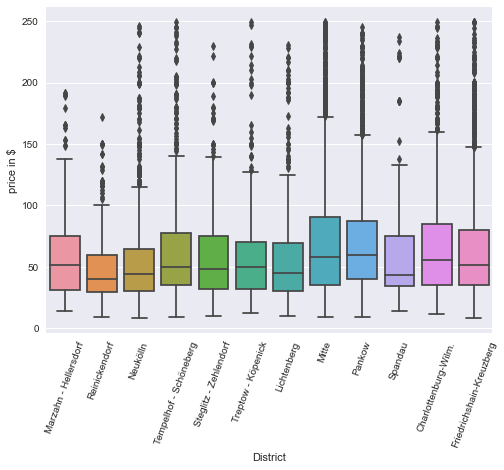

In [73]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
#ax.set_yscale('log')

df_boxplot = df_listings_sum_geo[['neighbourhood_group_cleansed','price_n','price_25%','price_50%','price_75%']]
df_boxplot = df_boxplot.sort_values(by='price_50%')
#df_boxplot.boxplot(column='price', by='zip', ax=ax, rot=90)
chart = sns.boxplot(x='neighbourhood_group_cleansed', y='price_n', data=df_boxplot, ax=ax)
plt.xticks(rotation=70);
chart.set_xlabel('District')
chart.set_ylabel('price in $')

In [74]:
df_boxplot.groupby(by='neighbourhood_group_cleansed').median().sort_values(by='price_n')

,price_n,price_25%,price_50%,price_75%
neighbourhood_group_cleansed,,,,
Reinickendorf,40.000000,30.000000,40.000000,60.000000
Spandau,43.306630,34.431490,44.786704,54.500000
Neukölln,44.000000,30.000000,42.182320,60.042917
Lichtenberg,45.000000,30.000000,40.354571,66.620610
Steglitz - Zehlendorf,48.000000,35.000000,48.500000,75.000000
Tempelhof - Schöneberg,50.000000,35.000000,50.000000,75.000000
Treptow - Köpenick,50.000000,35.436288,50.009669,73.627083
Friedrichshain-Kreuzberg,50.911602,35.162983,50.000000,80.000000
Marzahn - Hellersdorf,51.000000,34.000000,55.000000,72.113260


In [75]:
# offers per neighbourhood_group
df_listings_sum_geo[['id','neighbourhood_group_cleansed']].groupby(by='neighbourhood_group_cleansed').count().sort_values(by='id').rename(columns={'id':'num of offers'})

,num of offers
neighbourhood_group_cleansed,
Spandau,135
Marzahn - Hellersdorf,139
Reinickendorf,278
Steglitz - Zehlendorf,395
Lichtenberg,605
Treptow - Köpenick,628
Tempelhof - Schöneberg,1302
Charlottenburg-Wilm.,1582
Neukölln,2681


In [76]:
df_listings_sum_geo.groupby(by=['room_type','neighbourhood_group_cleansed'])['price_n'].describe()

count        mean        std  \
room_type       neighbourhood_group_cleansed                                  
Entire home/apt Charlottenburg-Wilm.           886.0   80.946490  43.252727   
                Friedrichshain-Kreuzberg      2304.0   82.061390  39.444207   
                Lichtenberg                    292.0   73.120564  39.477461   
                Marzahn - Hellersdorf           72.0   82.137312  47.292957   
                Mitte                         2421.0   90.506632  48.243050   
                Neukölln                      1252.0   68.484048  33.209054   
                Pankow                        1904.0   84.485350  42.272159   
                Reinickendorf                  131.0   64.432371  33.362308   
                Spandau                         79.0   70.518650  53.481118   
                Steglitz - Zehlendorf          212.0   76.133731  42.338745   
                Tempelhof - Schöneberg         676.0   77.585387  38.567324   
                Treptow - Köpenick             374.0   69.500365  34.946406   
Hotel room      Charlottenburg-Wilm.            15.0  129.112160  63.899404   
                Friedrichshain-Kreuzberg        25.0  127.861617  51.220435   
                Lichtenberg                      8.0  211.754243  15.171720   
                Marzahn - Hellersdorf            1.0  190.000000        NaN   
                Mitte                           36.0  120.012168  54.393456   
                Pankow                          22.0  144.196770  50.359717   
                Spandau                          8.0  161.864379  61.130119   
                Steglitz - Zehlendorf            1.0   31.209945        NaN   
                Tempelhof - Schöneberg           7.0  193.738314  25.203860   
Private room    Charlottenburg-Wilm.           664.0   46.263817  30.886771   
                Friedrichshain-Kreuzberg      2004.0   41.411566  20.371659   
                Lichtenberg                    286.0   36.741464  23.769618   
                Marzahn - Hellersdorf           63.0   43.774181  23.363685   
                Mitte                         1625.0   43.065431  27.383627   
                Neukölln                      1416.0   36.888623  18.816898   
                Pankow                        1102.0   42.597417  22.971202   
                Reinickendorf                  143.0   35.880714  18.325067   
                Spandau                         47.0   39.366711  19.315762   
                Steglitz - Zehlendorf          177.0   39.031806  19.887424   
                Tempelhof - Schöneberg         604.0   41.497578  26.852858   
                Treptow - Köpenick             248.0   41.618256  33.999854   
Shared room     Charlottenburg-Wilm.            17.0   35.857873  26.069208   
                Friedrichshain-Kreuzberg        70.0   49.125297  34.507447   
                Lichtenberg                     19.0   26.190635  17.319542   
                Marzahn - Hellersdorf            3.0   31.666667  20.816660   
                Mitte                          104.0   41.035551  31.153233   
                Neukölln                        13.0   24.494005  11.069028   
                Pankow                          21.0   63.713386  54.153644   
                Reinickendorf                    4.0   47.887458  68.214130   
                Spandau                          1.0   50.000000        NaN   
                Steglitz - Zehlendorf            5.0   65.400000  27.171676   
                Tempelhof - Schöneberg          15.0   35.033307  45.782828   
                Treptow - Köpenick               6.0   31.641736  13.100007   

                                                     min         25%  \
room_type       neighbourhood_group_cleansed                           
Entire home/apt Charlottenburg-Wilm.           20.000000   50.000000   
                Friedrichshain-Kreuzberg       15.000000   55.000000   
                Lichtenberg                  

### Identify outliers

In [77]:
df_outs = df_listings_sum_geo[['id','neighbourhood_group_cleansed','price_n']]
stats = df_outs.describe(percentiles=[0.05,0.25,0.5,0.75,0.99])
stats

,id,price_n
count,1.938300e+04,19383.000000
mean,2.418669e+07,63.809181
std,1.419931e+07,41.273005
min,1.944000e+03,8.000000
5%,1.880012e+06,21.023768
25%,1.188641e+07,35.000000
50%,2.305319e+07,50.005525
75%,3.738449e+07,80.000000
99%,4.808505e+07,211.105193
max,4.861566e+07,249.685083


In [78]:
df_outs[df_outs['price_n']>stats.loc['99%','price_n']].head()

,id,neighbourhood_group_cleansed,price_n
239,9985964,Mitte,220.000000
308,17970711,Mitte,239.307479
378,26508423,Mitte,221.444751
424,31842746,Mitte,229.234807
464,36367710,Pankow,230.000000


In [79]:
df_out_dtls = pd.merge(left=df_listings_dtl_cln, right=df_outs[df_outs['price_n']>stats.loc['99%','price_n']], on='id', how='inner')

In [80]:
df_out_dtls.shape

(194, 70)

In [81]:
df_out_dtls['property_type'].value_counts()

Entire apartment             117
others                        46
Entire serviced apartment     21
Entire loft                    6
Entire condominium             4
Name: property_type, dtype: int64

In [82]:
df_out_dtls['room_type'].value_counts()

Entire home/apt    165
Hotel room          15
Private room        14
Name: room_type, dtype: int64

In [83]:
df_out_dtls.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,picture_url,host_id,host_url,host_name,host_since,host_location,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed_x,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_in_days,minimum_nights,maximum_nights,price_n_x,adjusted_price_n,geometry,neighbourhood_group_cleansed_y,price_n_y
0,57049,https://www.airbnb.com/rooms/57049,20210312174442,2021-03-15,130 sqm with a view on Mauer Park,An apartment of 130 sqm right in the heart of ...,https://a0.muscache.com/pictures/miso/Hosting-...,54283,https://www.airbnb.com/users/show/54283,Marine,2009-11-14,"Berlin, Berlin, Germany",t,https://a0.muscache.com/im/users/54283/profile...,https://a0.muscache.com/im/users/54283/profile...,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Prenzlauer Berg Nordwest,Pankow,52.54787,13.40417,Entire apartment,Entire home/apt,4,2 or more bath,2.0,3.0,"[""Dishes and silverware"", ""Kitchen"", ""Oven"", ""...",$230.00,3.0,3.0,15.0,15.0,3.0,15.0,t,28,58,88,268,2021-03-15,93,0,0,2010-11-30,2020-01-02,98.0,10.0,10.0,10.0,10.0,10.0,9.0,f,3,3,0,0,0.74,4216.0,3.000000,15.0,230.000000,230.000000,POINT (13.40417 52.54787),Pankow,230.000000
1,195413,https://www.airbnb.com/rooms/195413,20210312174442,2021-03-14,Residential floor space in Mexicopl,<b>The space</b><br />Spacious apartment for u...,https://a0.muscache.com/pictures/1758006/45c1a...,897302,https://www.airbnb.com/users/show/897302,Paul,2011-07-31,"Berlin, Berlin, Germany",f,https://a0.muscache.com/im/users/897302/profil...,https://a0.muscache.com/im/users/897302/profil...,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,others,Steglitz - Zehlendorf,52.43469,13.23076,Entire apartment,Entire home/apt,4,1 bath,2.0,4.0,"[""Dishes and silverware"", ""Kitchen"", ""Oven"", ""...",$230.00,183.0,183.0,730.0,730.0,183.0,730.0,t,28,58,88,363,2021-03-14,9,0,0,2012-11-12,2016-07-10,93.0,10.0,10.0,9.0,10.0,10.0,9.0,f,4,4,0,0,0.09,3592.0,183.000000,730.0,230.000000,230.000000,POINT (13.23076 52.43469),Steglitz - Zehlendorf,230.000000
2,311703,https://www.airbnb.com/rooms/311703,20210312174442,2021-03-16,Elegant 4 Room Apartment with 2 Bathrooms,Our spacious and elegant Berlin apartment is p...,https://a0.muscache.com/pictures/2325ae7d-fb86...,1602903,https://www.airbnb.com/users/show/1602903,Kathrin,2012-01-13,"Berlin, Berlin, Germany",t,https://a0.muscache.com/im/users/1602903/profi...,https://a0.muscache.com/im/users/1602903/profi...,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Schöneberg-Nord,Tempelhof - Schöneberg,52.49599,13.35716,Entire apartment,Entire home/apt,8,2 or more bath,3 or more,5 or more,"[""Dishes and silverware"", ""Kitchen"", ""Oven"", ""...",$199.00,3.0,5.0,1125.0,1125.0,3.0,1125.0,t,28,58,88,342,2021-03-16,189,7,1,2012-05-27,2021-02-24,98.0,10.0,10.0,10.0,10.0,10.0,9.0,t,1,1,0,0,1.76,3426.0,3.027778,1125.0,249.394444,249.394444,POINT (13.35716 52.49599),Tempelhof - Schöneberg,249.394444


## Q2 - Price over period

How does the price vary over time? Are there any peak periods?

In [84]:
df_calendar.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,price_n,adjusted_price_n,date_d
0,64014,2021-03-14,f,$150.00,$150.00,2.0,365.0,150.0,150.0,2021-03-14
1,192050,2021-03-14,f,$48.00,$48.00,183.0,360.0,48.0,48.0,2021-03-14


In [85]:
df_calendar[df_calendar['listing_id']==64014].head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,price_n,adjusted_price_n,date_d
0,64014,2021-03-14,f,$150.00,$150.00,2.0,365.0,150.0,150.0,2021-03-14
1130,64014,2021-03-15,t,$150.00,$150.00,2.0,365.0,150.0,150.0,2021-03-15
1164,64014,2021-03-16,t,$150.00,$150.00,2.0,365.0,150.0,150.0,2021-03-16
1165,64014,2021-03-17,t,$150.00,$150.00,2.0,365.0,150.0,150.0,2021-03-17
1166,64014,2021-03-18,t,$150.00,$150.00,2.0,365.0,150.0,150.0,2021-03-18


In [86]:
df_cal_mean = df_calendar.groupby(by='date_d').mean()
df_cal_cnt  = df_calendar.groupby(by='date_d').count()
df_cal_mean_wk = df_calendar.groupby(by=df_calendar['date_d'].dt.isocalendar().week).mean()

df_rolling_median = df_cal_mean.rolling(7, center=True).mean()['price_n']

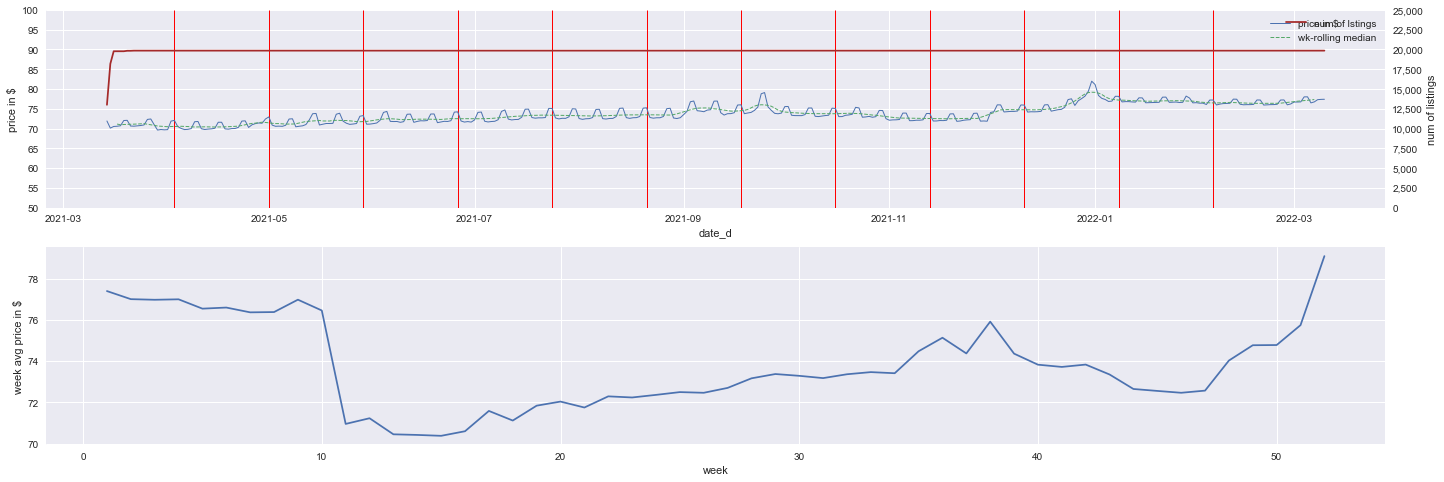

In [87]:
fig, ax = plt.subplots(2,1, figsize=(24,8))
sns.lineplot(x='date_d', y='price_n',data=df_cal_mean, ax=ax[0], label='price in $',  linewidth=1)

ax2 = ax[0].twinx()
ax2.grid(None)
ax2.get_yaxis().set_major_formatter( ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.lineplot(x='date_d', y='listing_id', data=df_cal_cnt, ax=ax2, color='brown', label='num of lstings')

sns.lineplot(x='week', y='price_n',data=df_cal_mean_wk, ax=ax[1])

ax[0].set_ylabel('price in $')
ax2.set_ylabel('num of listings')
ax[1].set_ylabel('week avg price in $')

nticks=11
ax[0].set_ylim(50,100)
ax2.set_ylim(0,25000)
ax[0].yaxis.set_major_locator(ticker.LinearLocator(nticks))
ax2.yaxis.set_major_locator(ticker.LinearLocator(nticks))

# rolling median
sns.lineplot(data=df_rolling_median, ax=ax[0], label='wk-rolling median', linestyle='--', linewidth=1)


# draw saturday 4 weekly
saturdays = pd.date_range(start='4/3/2021', periods=12, freq='28D').values
ax[0].vlines(saturdays, ymin=0, ymax=100, colors='r', linewidth=1, label='sat')


In [88]:
df_cal_mean['price_n'].nlargest(15)

date_d
2021-12-31    81.971336
2022-01-01    81.128961
2021-12-30    79.411617
2021-09-25    79.094907
2021-09-24    78.791043
2022-01-02    78.366581
2022-01-28    78.205582
2021-12-29    78.178329
2022-01-07    78.152587
2022-01-08    78.135761
2022-03-05    78.015113
2022-03-04    78.005491
2022-01-22    77.947056
2022-01-21    77.932950
2022-01-14    77.764999
Name: price_n, dtype: float64

### Results 2

* The price average on weekends (Fr, Sat) is higher than during the week. Fr, Sat price average has a clear peak.
* There is also a clear overall peak at the 31-December (Sylvester party in the capital)
* mid of March the number of offers drop because of the calendar time horizont. So we ignore the data as this is falsified by missing data

#### Price Differences by property type

In [89]:

grp = df_listings_dtl_cln.groupby('property_type')
grp['price_n'].median()

property_type
Entire apartment              69.000000
Entire condominium            80.000000
Entire loft                   95.805556
Entire serviced apartment    122.469613
Private room in apartment     35.000000
Private room in house         35.000000
others                        58.000000
Name: price_n, dtype: float64

<AxesSubplot:xlabel='property_type', ylabel='price in $'>

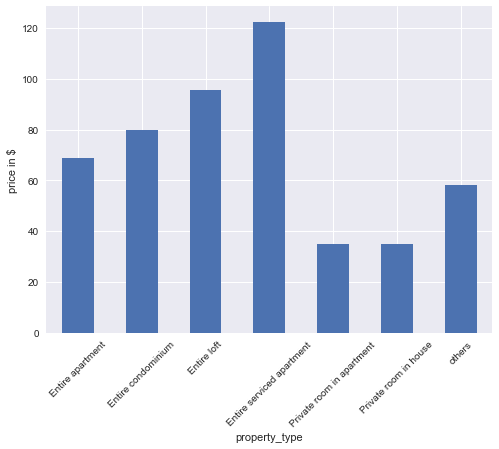

In [90]:
grp['price_n'].median().plot.bar(rot=45, figsize=(8,6), ylabel='price in $')

## Q3 - Amenities Analysis

In [91]:
df_amenities = df_listings_dtl_cln.copy(deep=True)
df_amenities['amenities_list'] = df_amenities['amenities'].str.slice(1,-1).str.replace('"','').str.split(', ')
df_amenities['price_qbin'] = pd.qcut(df_amenities['price_n'], 4)

In [92]:
#
# count amenities and ignore each that does not at least 10 times occur
#
amenities_count = {}
for i, row in enumerate(df_amenities['amenities_list']):
    for entry in row:                
        amenities_count[entry] = amenities_count.get(entry,0) +1
    

amenities_count = pd.Series(amenities_count)
amenities_count = amenities_count[amenities_count>10]

df_amenities = df_amenities.append(pd.DataFrame(columns=amenities_count.index.values))
df_amenities[amenities_count.index.values] = 0


In [93]:
print(f'Number of amenities types     : {amenities_count.shape[0]}')
print(f'Number of amenities types > 10: {amenities_count.shape[0]}')
print(f'Top 10 amenities:\n{amenities_count.nlargest(10)}')
print()
print(f'Bottom 10 amenities:\n{amenities_count.nsmallest(10)}')

Number of amenities types     : 143
Number of amenities types > 10: 143
Top 10 amenities:
Wifi                       18500
Heating                    18336
Kitchen                    18100
Essentials                 17769
Washer                     15596
Long term stays allowed    14464
Hair dryer                 13672
Hangers                    13156
Dedicated workspace        13050
Hot water                  10809
dtype: int64

Bottom 10 amenities:
Bidet                                           11
HDTV with Netflix                               11
Sound system with Bluetooth and aux             11
Free washer\u2013In building                    11
Stainless steel electric stove                  11
Amazon Prime Video                              11
Fire pit                                        12
Paid parking lot on premises                    12
Paid parking lot on premises \u2013 5 spaces    12
Clothing storage: dresser and wardrobe          13
dtype: int64


In [94]:
# set the dummy var column according to existence of the feature in amenities_list
for key in amenities_count.index:        
    df_amenities.loc[ df_amenities['amenities_list'].apply(lambda x: key in x), key] = 1
    
        

In [95]:
df_grp = df_amenities[['price_qbin'] + amenities_count.index.values.tolist()].groupby('price_qbin').sum()
df_grp

,Dishes and silverware,Kitchen,Oven,Stove,Patio or balcony,Luggage dropoff allowed,Dishwasher,Iron,Essentials,Hangers,Hot water,Refrigerator,Clothing storage,Toaster,Cooking basics,Pour-over coffee,Cleaning products,Dedicated workspace,Drying rack for clothing,Smoke alarm,Bed linens,Long term stays allowed,Free street parking,Wifi,Baking sheet,Host greets you,Hair dryer,Heating,Washer,Extra pillows and blankets,Lock on bedroom door,Lockbox,Bathtub,Microwave,Cable TV,Garden or backyard,Gym,Coffee maker,Shampoo,TV,Carbon monoxide alarm,First aid kit,Fire extinguisher,Dryer,Air conditioning,Elevator,Single level home,Pack \u2019n Play/travel crib,Paid parking off premises,Room-darkening shades,Children\u2019s dinnerware,High chair,Children\u2019s books and toys,Babysitter recommendations,Crib,Private entrance,Ethernet connection,Building staff,Indoor fireplace,Baby bath,Hot water kettle,Cleaning before checkout,Wine glasses,Paid parking on premises,Smart lock,Outlet covers,Body soap,Changing table,Freezer,Laundromat nearby,Shower gel,Waterfront,Free parking on premises,Lake access,Bidet,Game console,EV charger,Central heating,HDTV with Netflix,Washer \u2013\u00a0In unit,Electric stove,Portable fans,Nespresso machine,Dining table,Clothing storage: wardrobe,Self check-in,Full kitchen,Bathroom essentials,Bedroom comforts,Hot tub,Window guards,Baby monitor,Sound system with Bluetooth and aux,Rice maker,BBQ grill,Barbecue utensils,Breakfast,HDTV,Conditioner,Pool,Gas stove,Keypad,Bikes,Induction stove,Board games,Outdoor dining area,Free washer\u2013In unit,Mini fridge,Pocket wifi,Sound system,Piano,Clothing storage: closet,Baby safety gates,Clothing storage: dresser and wardrobe,Washer \u2013\u00a0In building,Record player,Outdoor furniture,Beach essentials,Table corner guards,Dryer \u2013 In building,Trash compactor,Bread maker,Safe,Beachfront,Mosquito net,Fireplace guards,Ceiling fan,Dedicated workspace: table,Free washer\u2013In building,Keurig coffee machine,Ski-in/Ski-out,Stainless steel oven,Paid street parking off premises,Paid parking garage off premises,Bluetooth sound system,Sound system with aux,Fire pit,Stainless steel electric stove,Wifi \u2013 100 Mbps,Paid parking lot on premises,Amazon Prime Video,Paid parking garage on premises,Paid parking lot on premises \u2013 5 spaces
price_qbin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(7.999, 35.0]",1625,4888,1245,1305,574,655,769,2240,4664,3006,2265,1537,29,50,1447,28,49,3307,41,1810,1220,3586,1250,4973,228,1039,3145,4860,4384,666,1395,94,263,709,364,268,46,985,1990,1459,499,897,580,561,77,716,215,25,194,141,28,34,66,21,35,349,114,18,79,15,72,165,52,52,11,24,90,13,124,42,215,54,562,57,3,26,67,13,0,3,12,44,29,48,9,0,0,0,0,126,18,4,0,22,55,35,275,2,29,13,3,7,9,3,7,8,2,22,22,20,22,3,6,1,5,4,9,23,1,3,5,24,5,3,3,0,2,7,2,7,19,5,4,3,2,5,2,2,4,0,1,1,0
"(35.0, 50.006]",1870,4148,1362,1481,721,666,885,2304,4102,2866,2419,1739,38,48,1669,32,62,2917,49,1848,1380,3180,1280,4227,291,1059,2999,4215,3622,733,935,136,343,681,524,311,39,1198,2167,1801,510,802,541,598,80,764,288,89,317,224,76,118,173,51,93,661,143,36,93,43,76,167,56,101,21,62,132,47,139,70,344,51,461,43,4,49,80,17,1,8,13,59,25,50,10,0,0,0,0,107,42,22,5,25,78,34,236,0,41,11,5,16,8,8,8,5,3,25,29,32,9,3,9,3,11,13,5,22,10,4,7,20,6,3,6,1,4,1,1,8,9,4,14,3,2,3,2,2,3,0,0,2,1
"(50.006, 80.0]",2496,4799,1794,2010,1122,837,1230,2942,4751,3629,3055,2331,42,92,2256,61,88,3442,71,2404,1839,3924,1465,4876,429,1092,3767,4860,4034,951,498,277,499,994,914,395,64,1767,2632,2776,775,962,837,860,119,1047,502,269,492,370,165,376,341,76,263,1190,226,104,126,104,111,176,90,140,39,117,192,96,215,90,465,84,572,71,3,67,98,24,7,17,32,99,67,93,15,1,3,4,4,107,74,35,4,18,109,51,299,6,63,25,4,49,9,28,16,20,6,47,51,54,28,9,17,6,14,24,19,27,15,11,6,17,8,9,6,5,10,3,2,11,11,8,30,2,5,2,5,3,2,2,5,2,9
"(80.0, 249.685]",2776,4265,2036,2398,1373,1012,1867,3203,4252,3655

In [96]:
df_grp_rel = df_grp / df_grp.sum()
df_grp_rel.style.background_gradient(cmap='YlOrRd')


,Dishes and silverware,Kitchen,Oven,Stove,Patio or balcony,Luggage dropoff allowed,Dishwasher,Iron,Essentials,Hangers,Hot water,Refrigerator,Clothing storage,Toaster,Cooking basics,Pour-over coffee,Cleaning products,Dedicated workspace,Drying rack for clothing,Smoke alarm,Bed linens,Long term stays allowed,Free street parking,Wifi,Baking sheet,Host greets you,Hair dryer,Heating,Washer,Extra pillows and blankets,Lock on bedroom door,Lockbox,Bathtub,Microwave,Cable TV,Garden or backyard,Gym,Coffee maker,Shampoo,TV,Carbon monoxide alarm,First aid kit,Fire extinguisher,Dryer,Air conditioning,Elevator,Single level home,Pack \u2019n Play/travel crib,Paid parking off premises,Room-darkening shades,Children\u2019s dinnerware,High chair,Children\u2019s books and toys,Babysitter recommendations,Crib,Private entrance,Ethernet connection,Building staff,Indoor fireplace,Baby bath,Hot water kettle,Cleaning before checkout,Wine glasses,Paid parking on premises,Smart lock,Outlet covers,Body soap,Changing table,Freezer,Laundromat nearby,Shower gel,Waterfront,Free parking on premises,Lake access,Bidet,Game console,EV charger,Central heating,HDTV with Netflix,Washer \u2013\u00a0In unit,Electric stove,Portable fans,Nespresso machine,Dining table,Clothing storage: wardrobe,Self check-in,Full kitchen,Bathroom essentials,Bedroom comforts,Hot tub,Window guards,Baby monitor,Sound system with Bluetooth and aux,Rice maker,BBQ grill,Barbecue utensils,Breakfast,HDTV,Conditioner,Pool,Gas stove,Keypad,Bikes,Induction stove,Board games,Outdoor dining area,Free washer\u2013In unit,Mini fridge,Pocket wifi,Sound system,Piano,Clothing storage: closet,Baby safety gates,Clothing storage: dresser and wardrobe,Washer \u2013\u00a0In building,Record player,Outdoor furniture,Beach essentials,Table corner guards,Dryer \u2013 In building,Trash compactor,Bread maker,Safe,Beachfront,Mosquito net,Fireplace guards,Ceiling fan,Dedicated workspace: table,Free washer\u2013In building,Keurig coffee machine,Ski-in/Ski-out,Stainless steel oven,Paid street parking off premises,Paid parking garage off premises,Bluetooth sound system,Sound system with aux,Fire pit,Stainless steel electric stove,Wifi \u2013 100 Mbps,Paid parking lot on premises,Amazon Prime Video,Paid parking garage on premises,Paid parking lot on premises \u2013 5 spaces
price_qbin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(7.999, 35.0]",0.185354,0.270055,0.193413,0.181401,0.151451,0.206625,0.161861,0.209561,0.262480,0.228489,0.209548,0.186869,0.207143,0.196850,0.182725,0.187919,0.188462,0.253410,0.193396,0.203165,0.184290,0.247926,0.235449,0.268811,0.162162,0.252123,0.230032,0.265052,0.281098,0.202186,0.458429,0.092611,0.143324,0.194034,0.123852,0.181942,0.178295,0.158820,0.209231,0.156612,0.172784,0.228885,0.169146,0.170103,0.140000,0.179899,0.126769,0.026795,0.107658,0.111374,0.050725,0.025074,0.058771,0.078067,0.033751,0.098532,0.158996,0.061017,0.148496,0.038860,0.203390,0.257410,0.192593,0.086379,0.051163,0.068182,0.149502,0.044068,0.189313,0.140468,0.137205,0.186207,0.259345,0.232653,0.272727,0.111588,0.204268,0.162500,0.000000,0.061224,0.155844,0.144737,0.142857,0.182510,0.209302,0.000000,0.000000,0.000000,0.000000,0.287016,0.066421,0.035088,0.000000,0.271605,0.121951,0.170732,0.263663,0.133333,0.155914,0.156627,0.214286,0.027668,0.236842,0.057692,0.155556,0.166667,0.095238,0.176000,0.146667,0.131579,0.250000,0.157895,0.098361,0.076923,0.125000,0.071429,0.173077,0.247312,0.023256,0.130435,0.217391,0.300000,0.208333,0.142857,0.176471,0.000000,0.086957,0.411765,0.181818,0.205882,0.380000,0.200000,0.052632,0.214286,0.142857,0.294118,0.166667,0.181818,0.307692,0.000000,0.090909,0.066667,0.000000
"(35.0, 50.006]",0.213300,0.229171,0.211589,0.205866,0.190237,0.210095,0.186277,0.215549,0.230851,0.217847,0.223795,0.211429,0.271429,0.188976,0.210759,0.214765,0.238462,0.223525,0.231132,0.207431,0.208459,0.219856,0.2411

In [97]:
df_grp_rel[df_grp_rel.iloc[3,:][df_grp_rel.iloc[3,:]>0.4].nlargest(15).index].style.background_gradient(cmap='YlOrRd')

,Self check-in,Bathroom essentials,Bedroom comforts,Full kitchen,Paid parking lot on premises,Keypad,Fireplace guards,Smart lock,Paid parking garage on premises,Crib,High chair,Pack \u2019n Play/travel crib,Baby bath,Free washer\u2013In building,Paid parking on premises
price_qbin,,,,,,,,,,,,,,,
"(7.999, 35.0]",0.000000,0.000000,0.000000,0.000000,0.000000,0.027668,0.000000,0.051163,0.066667,0.033751,0.025074,0.026795,0.038860,0.181818,0.086379
"(35.0, 50.006]",0.000000,0.000000,0.000000,0.000000,0.000000,0.063241,0.047619,0.097674,0.133333,0.089682,0.087021,0.095391,0.111399,0.090909,0.167774
"(50.006, 80.0]",0.071429,0.133333,0.133333,0.136364,0.166667,0.193676,0.238095,0.181395,0.133333,0.253616,0.277286,0.288317,0.269430,0.181818,0.232558
"(80.0, 249.685]",0.928571,0.866667,0.866667,0.863636,0.833333,0.715415,0.714286,0.669767,0.666667,0.622951,0.610619,0.589496,0.580311,0.545455,0.513289


In [98]:
df_grp_rel.iloc[3,:][df_grp_rel.iloc[3,:]>0.4].nlargest(15)

Self check-in                      0.928571
Bathroom essentials                0.866667
Bedroom comforts                   0.866667
Full kitchen                       0.863636
Paid parking lot on premises       0.833333
Keypad                             0.715415
Fireplace guards                   0.714286
Smart lock                         0.669767
Paid parking garage on premises    0.666667
Crib                               0.622951
High chair                         0.610619
Pack \u2019n Play/travel crib      0.589496
Baby bath                          0.580311
Free washer\u2013In building       0.545455
Paid parking on premises           0.513289
Name: (80.0, 249.685], dtype: float64

### Result 3

The more expensive listing offers (top quantile - 75%) has much more often a larger amenities. There are also certain types of amenities like "Self-Check-In", "Full kitchen","Crib", "Bikes", "Airconditioning" that are strong indicators for offers in the top quantile.

## Q4

In [99]:
features = pd.Series(feature_cols_set_1)
features.drop(features[features.isin(['amenities','latitude','longitude','neighbourhood_cleansed'])].index, inplace=True)
features

0                  host_is_superhost
1             host_identity_verified
3       neighbourhood_group_cleansed
6                      property_type
7                          room_type
8                       accommodates
9                     bathrooms_text
10                          bedrooms
11                              beds
13                    minimum_nights
14                    maximum_nights
15                  has_availability
16                 number_of_reviews
17              review_scores_rating
18                  instant_bookable
19    calculated_host_listings_count
20                host_since_in_days
21                           price_n
dtype: object

In [100]:
cat_cols = df_listings_dtl_cln[features].dtypes[df_listings_dtl_cln[features].dtypes=='object']
num_cols = df_listings_dtl_cln[features].dtypes[(df_listings_dtl_cln[features].dtypes=='float64') | (df_listings_dtl_cln[features].dtypes=='int64')]


In [101]:
print(cat_cols)
print()
print(num_cols)

host_is_superhost               object
host_identity_verified          object
neighbourhood_group_cleansed    object
property_type                   object
room_type                       object
bathrooms_text                  object
bedrooms                        object
beds                            object
has_availability                object
instant_bookable                object
dtype: object

accommodates                        int64
minimum_nights                    float64
maximum_nights                    float64
number_of_reviews                   int64
review_scores_rating              float64
calculated_host_listings_count      int64
host_since_in_days                float64
price_n                           float64
dtype: object


In [102]:
num_cols_wo_price = num_cols[~ num_cols.index.isin(['price_n'])]
num_cols_wo_price

accommodates                        int64
minimum_nights                    float64
maximum_nights                    float64
number_of_reviews                   int64
review_scores_rating              float64
calculated_host_listings_count      int64
host_since_in_days                float64
dtype: object

### Fill Null Values

In [103]:
df_listings_dtl_cln[cat_cols.index].isnull().sum()

host_is_superhost               918
host_identity_verified          918
neighbourhood_group_cleansed      0
property_type                     0
room_type                         0
bathrooms_text                   17
bedrooms                          0
beds                              0
has_availability                  0
instant_bookable                  0
dtype: int64

In [104]:
df_listings_dtl_cln[num_cols.index].isnull().sum()

accommodates                         0
minimum_nights                       0
maximum_nights                       0
number_of_reviews                    0
review_scores_rating              4326
calculated_host_listings_count       0
host_since_in_days                 918
price_n                              0
dtype: int64

#### Fill numerical Null of numerical columns with Median

In [105]:
df_listings_dtl_cln[num_cols.index.values] = df_listings_dtl_cln[num_cols.index.values].fillna(value=df_listings_dtl_cln[num_cols.index.values].median())

### Create Dummy Vars

In [106]:
df_dummy = pd.get_dummies(df_listings_dtl_cln[cat_cols.index.values], drop_first=True)
df_numerical = df_listings_dtl_cln[num_cols_wo_price.index.values]
df_model = pd.concat([df_numerical, df_dummy], axis=1, join="inner")
df_model.head()

,accommodates,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,host_since_in_days,host_is_superhost_t,host_identity_verified_t,neighbourhood_group_cleansed_Friedrichshain-Kreuzberg,neighbourhood_group_cleansed_Lichtenberg,neighbourhood_group_cleansed_Marzahn - Hellersdorf,neighbourhood_group_cleansed_Mitte,neighbourhood_group_cleansed_Neukölln,neighbourhood_group_cleansed_Pankow,neighbourhood_group_cleansed_Reinickendorf,neighbourhood_group_cleansed_Spandau,neighbourhood_group_cleansed_Steglitz - Zehlendorf,neighbourhood_group_cleansed_Tempelhof - Schöneberg,neighbourhood_group_cleansed_Treptow - Köpenick,property_type_Entire condominium,property_type_Entire loft,property_type_Entire serviced apartment,property_type_Private room in apartment,property_type_Private room in house,property_type_others,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathrooms_text_1 shared bath,bathrooms_text_2 or more bath,bathrooms_text_2 or more shared bath,bathrooms_text_no bath,bedrooms_2.0,bedrooms_3 or more,bedrooms_nan,beds_1.0,beds_2.0,beds_3.0,beds_4.0,beds_5 or more,beds_nan,has_availability_t,instant_bookable_t
0,1,60.000000,120.0,18,82.0,3,4671.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,3,11.247191,1125.0,135,93.0,6,4669.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,4,62.000000,1125.0,147,93.0,1,4607.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,1,7.000000,35.0,27,89.0,1,4588.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2,7.000000,90.0,135,99.0,1,4407.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [107]:
df_model.isnull().sum()

accommodates                                             0
minimum_nights                                           0
maximum_nights                                           0
number_of_reviews                                        0
review_scores_rating                                     0
calculated_host_listings_count                           0
host_since_in_days                                       0
host_is_superhost_t                                      0
host_identity_verified_t                                 0
neighbourhood_group_cleansed_Friedrichshain-Kreuzberg    0
neighbourhood_group_cleansed_Lichtenberg                 0
neighbourhood_group_cleansed_Marzahn - Hellersdorf       0
neighbourhood_group_cleansed_Mitte                       0
neighbourhood_group_cleansed_Neukölln                    0
neighbourhood_group_cleansed_Pankow                      0
neighbourhood_group_cleansed_Reinickendorf               0
neighbourhood_group_cleansed_Spandau                    

In [108]:
df_model.shape

(19386, 44)

### Linear Regression with just quantitative features

In [109]:
X = df_numerical
y = df_listings_dtl_cln['price_n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [110]:
lm_model = linear_model.LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test)

In [111]:
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.33757698721860097 on 5816 values.'

In [112]:
lm_model.coef_

array([ 1.50580364e+01, -4.15770375e-02,  3.11659930e-08,  2.63358956e-02,
        3.51627472e-01,  6.60432025e-01, -1.67920177e-03])

### Linear Regression with all features

In [113]:
X = df_model
y = df_listings_dtl_cln['price_n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [114]:
lm_model = linear_model.LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

In [115]:
"The r-squared score for the model using all variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using all variables was 0.5046243191122197 on 5816 values.'

In [116]:
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [117]:
coef = list(zip(X_train.columns,lm_model.coef_))
m = X_train.columns.str.len().max()


# The mean squared error
print(f'Mean squared error Test: {mean_squared_error(y_test, y_test_preds):8.2f}')
print(f'Mean squared error Train: {mean_squared_error(y_train, y_train_preds):8.2f}')
print()

print(f'R-squared - Testdata: {test_score}')

r_sq_adj = 1 - (1-lm_model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print(f'R-squared-adjusted - Testdata: {r_sq_adj}\n')

r_sq_adj = 1 - (1-lm_model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(f'R-squared - Traindata: {train_score}')
print(f'R-squared-adjusted - Traindata: {r_sq_adj}\n')

print()
for c in coef:
    print(f'{c[0]:<{m}} : {c[1]:9.5f}')

Mean squared error Test:   814.02
Mean squared error Train:   843.77

R-squared - Testdata: 0.5046243191122197
R-squared-adjusted - Testdata: 0.5008474121707776

R-squared - Traindata: 0.5119108718488898
R-squared-adjusted - Traindata: 0.5103230033358659


accommodates                                          :   7.49214
minimum_nights                                        :  -0.08699
maximum_nights                                        :   0.00000
number_of_reviews                                     :   0.00572
review_scores_rating                                  :   0.23915
calculated_host_listings_count                        :   0.24918
host_since_in_days                                    :  -0.00144
host_is_superhost_t                                   :   6.15961
host_identity_verified_t                              :  -0.05723
neighbourhood_group_cleansed_Friedrichshain-Kreuzberg :   0.28968
neighbourhood_group_cleansed_Lichtenberg              :  -4.34654
neighbourhood_gro

In [118]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_preds))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_test_preds))

Mean squared error: 814.02
Coefficient of determination: 0.50


In [119]:
print('Coefficients')
lm_model.coef_

Coefficients


array([ 7.49213730e+00, -8.69935732e-02,  2.76445965e-08,  5.71780566e-03,
        2.39149814e-01,  2.49182766e-01, -1.44454997e-03,  6.15960864e+00,
       -5.72278111e-02,  2.89684894e-01, -4.34654035e+00, -1.58011423e+01,
        2.98540464e+00, -6.56815324e+00,  1.13953583e+00, -1.38254283e+01,
       -1.26987812e+01, -6.35406259e+00, -2.34858061e+00, -1.27483051e+01,
        8.44793795e+00,  2.15412791e+01,  3.71104415e+01, -1.25402209e+01,
       -7.00629962e+00,  6.94562828e+00,  5.52014834e+01, -9.45611627e+00,
       -3.72655199e+01, -3.73331508e+00,  1.70392283e+01, -6.15283638e+00,
        3.90004246e-01,  1.17737649e+01,  2.30885688e+01, -3.23657910e+00,
       -2.02173488e-01,  4.44462045e-02,  3.72261679e+00,  4.71915748e+00,
        4.75835953e+00,  1.42317433e+00,  6.95096947e+00,  2.56856496e+00])

In [120]:
lm_model.intercept_

21.120599082363796

In [121]:
1 - ((1-test_score))

0.5046243191122197

### Linear Regression with statsmodel OLS
OLS (Ordinary Least Squares) provides per default as Output Linear Regression Tables. We use this to compare it with the model from sklearn lib

In [122]:
from scipy import stats
import statsmodels.api as sm

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                price_n   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     322.4
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        19:49:03   Log-Likelihood:                -64972.
No. Observations:               13570   AIC:                         1.300e+05
Df Residuals:                   13525   BIC:                         1.304e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

## Linear Regression with Lasso

In [123]:
regr = linear_model.Lasso(alpha=0.05)
regr.fit(X_train, y_train)


Lasso(alpha=0.05)

In [124]:
res = regr.predict(X_test)
print(res)
print(regr.score(X_test,y_test))
print(regr.score(X_train,y_train))

[63.96833216 30.98606004 45.06086965 ... 63.45457455 83.78918651
 49.93871135]
0.5037774572681812
0.5097615327873927


In [125]:
res

array([63.96833216, 30.98606004, 45.06086965, ..., 63.45457455,
       83.78918651, 49.93871135])

In [126]:
print(regr.score(X_test,y_test))
print(regr.score(X_train,y_train))

0.5037774572681812
0.5097615327873927


In [127]:
print(regr.score(X_train,y_train))

0.5097615327873927


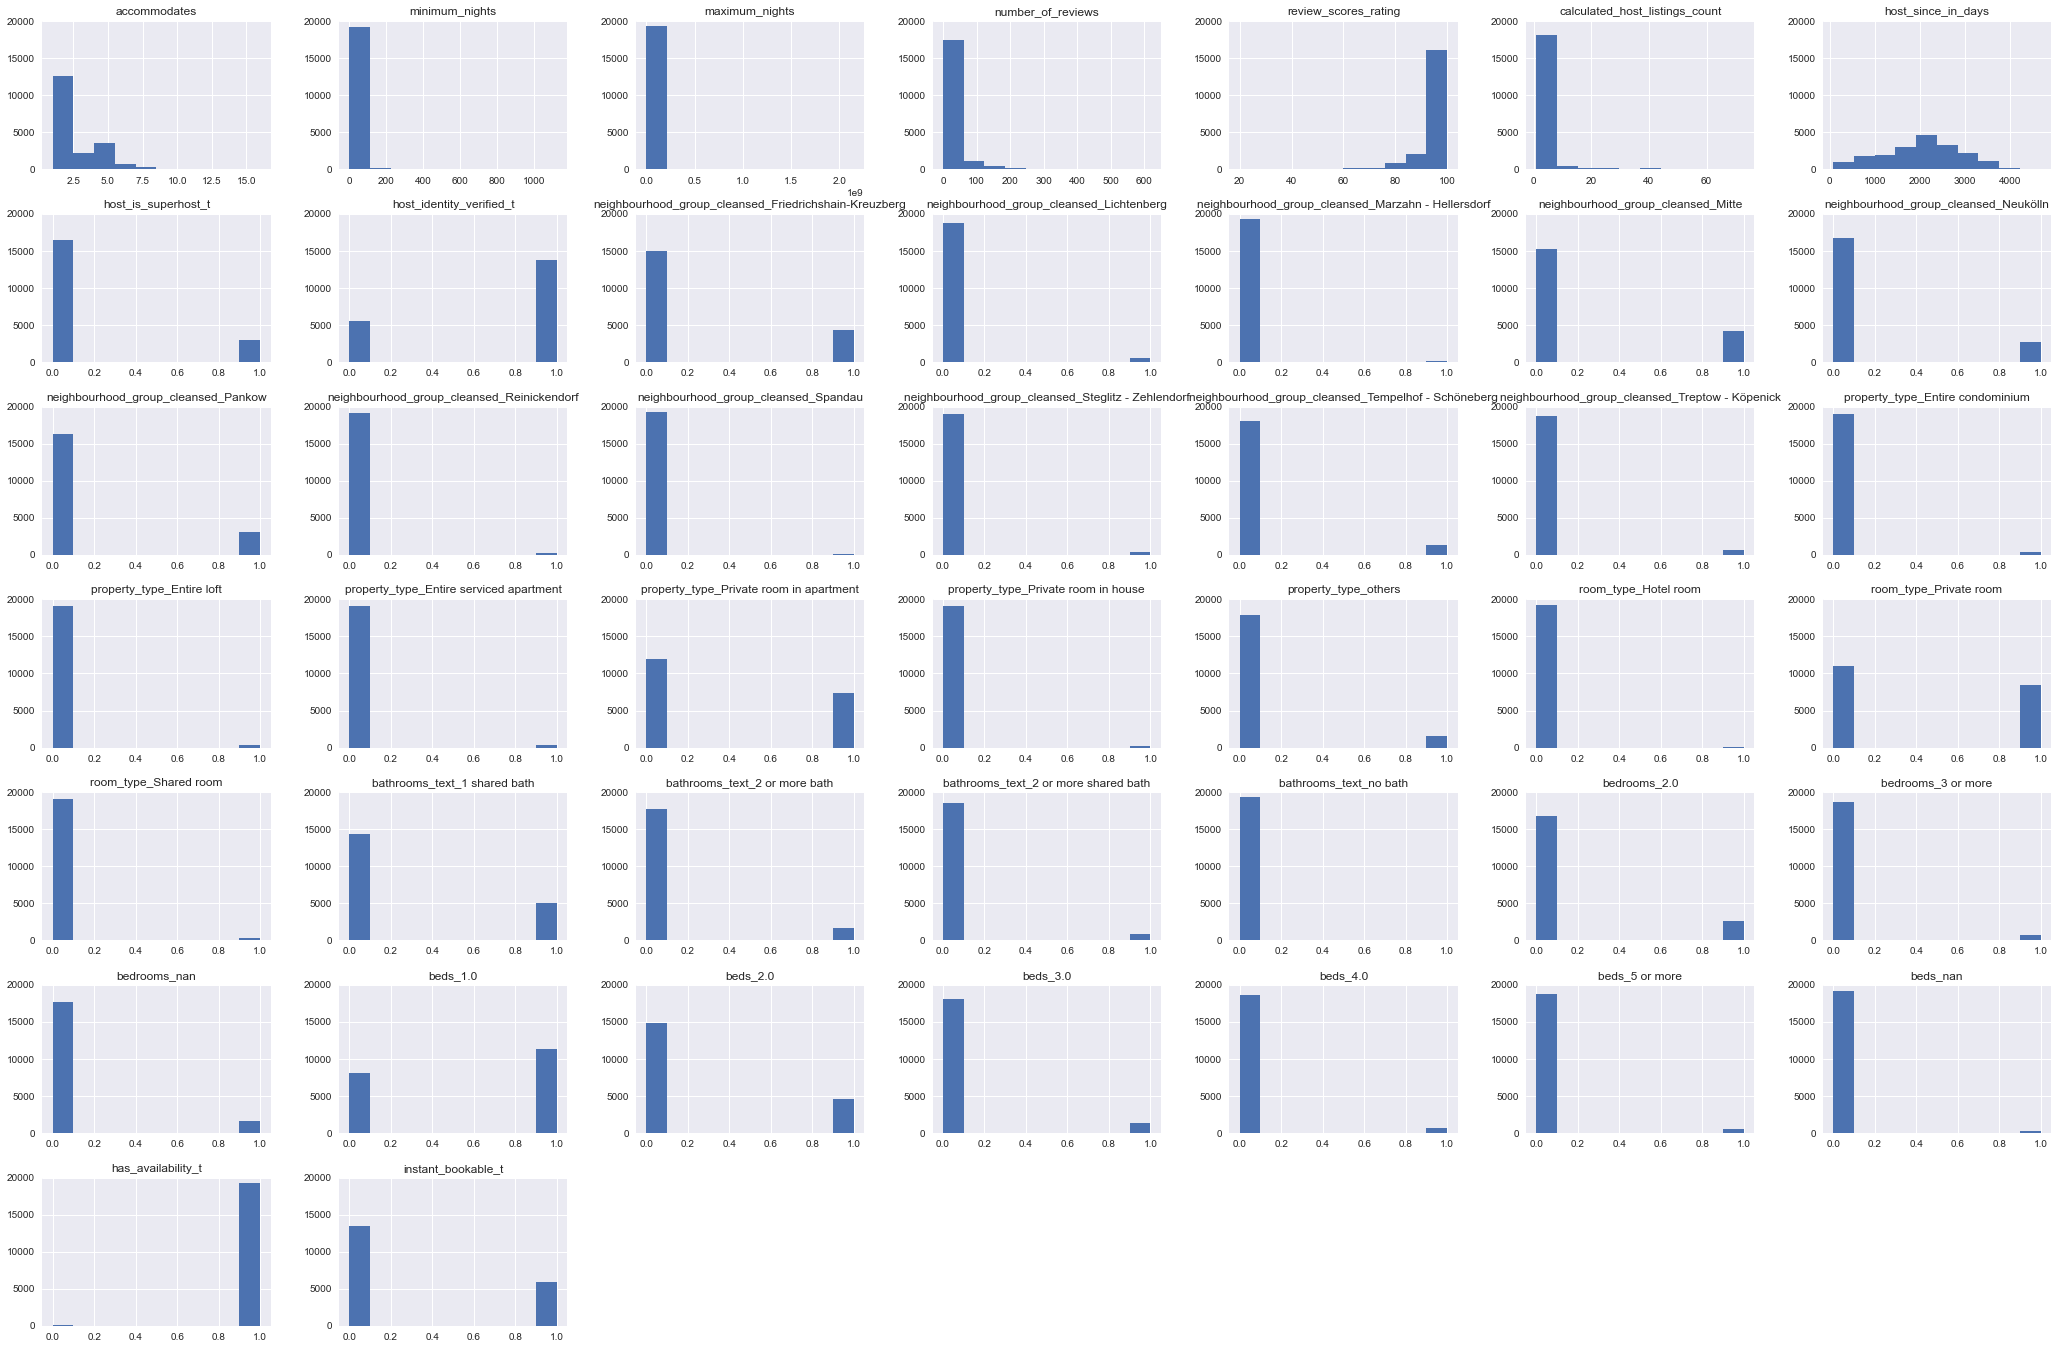

In [128]:
axes = df_model.hist(figsize=(36,24))
for a in axes:
    for b in a:
        b.set_ylim(0,20000)

<AxesSubplot:>

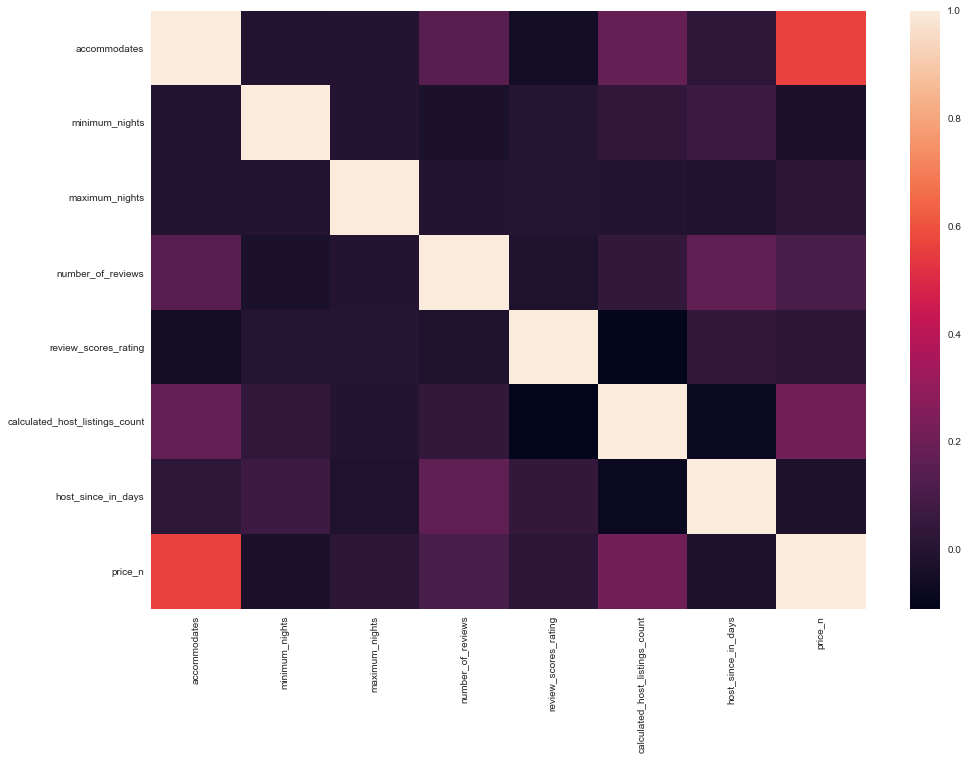

In [129]:
sns.heatmap(df_listings_dtl_cln[features].corr())

<AxesSubplot:>

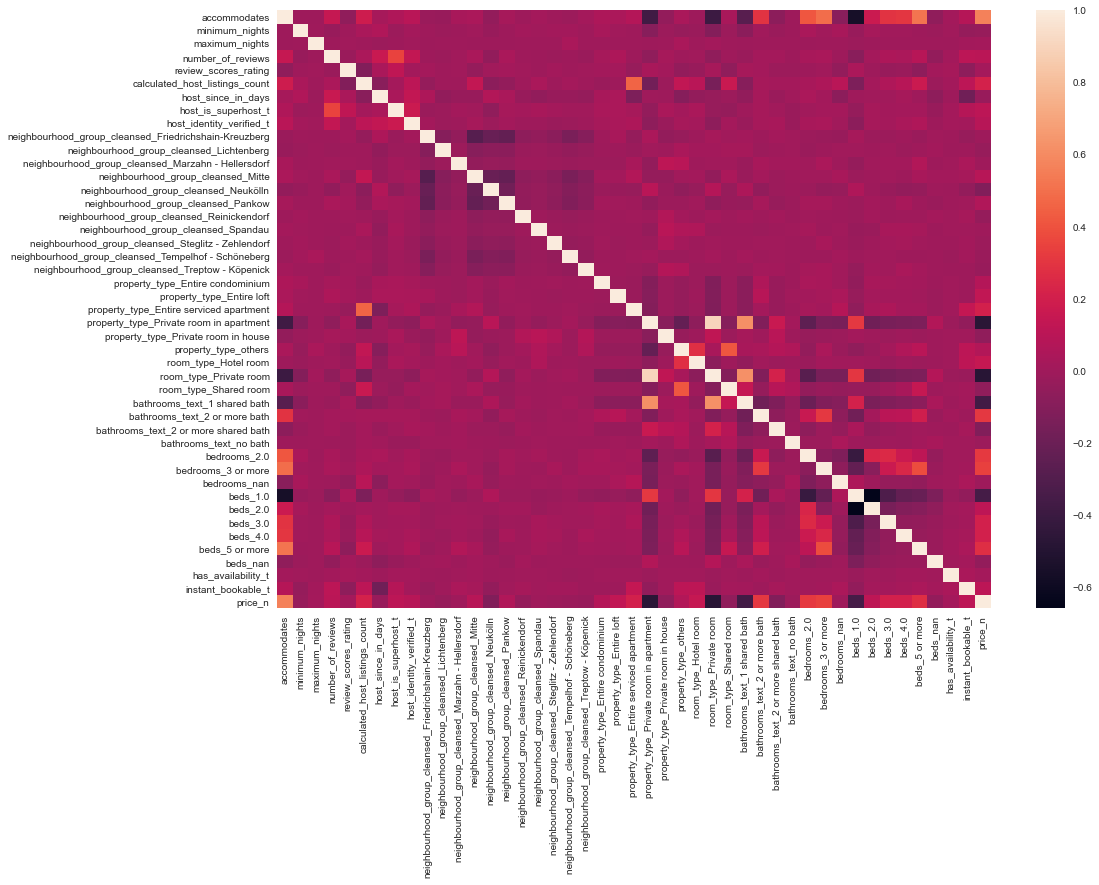

In [130]:
df_model_t = df_model.copy()
df_model_t['price_n'] = y
sns.heatmap(df_model_t.corr())